# N=1 Screening Results Analysis

This notebook analyzes the coarse screening results for N=1 with M ∈ {4, 5, 6, 7, 8, 9}.

**Key difference from N>1:** The utterance space is simpler:
- N=1: (quantifier, predicate) → 8 utterances (e.g., "all,successful")
- N>1: (quantifier1, quantifier2, predicate) → 32 utterances

# Stage 1: Extract and Process Data from Pickle Files

In [1]:
# """
# Unpacking and processing of N=1 coarse screening results.

# Two stages:
# 1. Retrieval: Extract core fields from pickle files
# 2. Processing: Derive additional columns for analysis
# """

# import pickle
# import numpy as np
# import pandas as pd
# from pathlib import Path
# import gc


# # =============================================================================
# # STAGE 1: RETRIEVAL - Extract core fields from pickle files
# # =============================================================================

# SPEAKER_KEY_TO_MODEL = {
#     "literal": "literal", "inf_T": "inf_T", "inf_F": "inf_F",
#     "persp_T": "persp_T", "persp_F": "persp_F",
#     "persm_T": "persm_T", "persm_F": "persm_F",
# }

# FITTED_KEY_TO_MODEL = {
#     "literal_fitted": "literal", "inf_T_fitted": "inf_T", "inf_F_fitted": "inf_F",
#     "persp_T_fitted": "persp_T", "persp_F_fitted": "persp_F",
#     "persm_T_fitted": "persm_T", "persm_F_fitted": "persm_F",
# }


# def _parse_alpha(alpha_val):
#     if alpha_val == "determ":
#         return 1000.0
#     try:
#         return float(alpha_val) if alpha_val is not None else np.nan
#     except (ValueError, TypeError):
#         return np.nan


# def _unpack_file(filepath: Path) -> pd.DataFrame:
#     """Extract core fields from a single pickle file."""
#     with open(filepath, "rb") as f:
#         obs_data = pickle.load(f)
    
#     meta = obs_data.get("_metadata", {})
#     N, M = meta.get("n"), meta.get("m")
#     Ts = obs_data["config"]["Ts"]
#     thetas = obs_data["config"]["thetas"]
    
#     rows = []
    
#     for theta in thetas:
#         for obs_id, obs_info in enumerate(obs_data["observations"][theta]):
#             if obs_info["utterances"] is None:
#                 continue
            
#             for speaker_key, alpha_dict in obs_info["utterances"].items():
#                 true_model = SPEAKER_KEY_TO_MODEL.get(speaker_key)
#                 if true_model is None:
#                     continue
                
#                 for _, utt_records in alpha_dict.items():
#                     for utt_id, utt_rec in enumerate(utt_records):
#                         true_ll_dict = utt_rec.get("log_lik_true_speaker", {})
#                         fitted_lls = utt_rec.get("log_lik_all_speaker", {})
#                         if not fitted_lls:
#                             continue
                        
#                         for T in Ts:
#                             true_ll = true_ll_dict.get(T, np.nan)
                            
#                             for fitted_key, fitted_data in fitted_lls.items():
#                                 fitted_model = FITTED_KEY_TO_MODEL.get(fitted_key)
#                                 if fitted_model is None:
#                                     continue
                                
#                                 fitted_ll = fitted_data.get("max_log_lik", {}).get(T, np.nan)
#                                 fitted_alpha = _parse_alpha(fitted_data.get("optimal_alpha", {}).get(T))
                                
#                                 rows.append((
#                                     N, M, theta, T, obs_id, utt_id,
#                                     true_model, fitted_model,
#                                     true_ll, fitted_ll, fitted_alpha
#                                 ))
    
#     del obs_data
#     gc.collect()
    
#     return pd.DataFrame(rows, columns=[
#         "N", "M", "theta", "T", "obs_id", "utt_id",
#         "true_model", "fitted_model",
#         "true_ll", "fitted_ll", "fitted_alpha"
#     ])


# def unpack_all(results_dir: str, pattern: str = "screen_N1_M*_T*.pkl") -> pd.DataFrame:
#     """Unpack all N=1 result files into a DataFrame with core fields only."""
#     files = sorted(Path(results_dir).glob(pattern))
#     if not files:
#         raise FileNotFoundError(f"No files matching '{pattern}' in {results_dir}")
    
#     print(f"Found {len(files)} files")
#     dfs = []
#     for f in files:
#         print(f"  {f.name}...", end=" ")
#         df = _unpack_file(f)
#         print(f"{len(df):,} rows")
#         dfs.append(df)
    
#     df_all = pd.concat(dfs, ignore_index=True)
#     print(f"Total: {len(df_all):,} rows, {df_all.memory_usage(deep=True).sum()/1e6:.2f} MB")
#     return df_all


# # =============================================================================
# # STAGE 2: PROCESSING - Derive additional columns for analysis
# # =============================================================================

# def process_df(df: pd.DataFrame) -> pd.DataFrame:
#     """
#     Apply all derived columns to the DataFrame.
    
#     Input columns (from retrieval):
#         N, M, theta, T, obs_id, utt_id,
#         true_model, fitted_model,
#         true_ll, fitted_ll, fitted_alpha
    
#     Output adds:
#         N_M              - "(N, M)" label (will always be "(1, M)" for this analysis)
#         true_psi         - goal type: literal, inf, persp, persm
#         true_update      - 0 if F/literal, 1 if T
#         fitted_psi       - goal type
#         fitted_update    - 0 if F/literal, 1 if T
#         psi_match        - 1 if same goal
#         update_match     - 1 if same update
#         ll_gap           - true_ll - fitted_ll
#         gap_alpha        - fitted_alpha - generating_alpha
#         theta_centered_abs - |theta - 0.5|
#         theta10          - theta * 10
#     """
#     df = df.copy()
    
#     # --- (N, M) label ---
#     df["N_M"] = pd.Categorical(
#         "(" + df["N"].astype("string") + ", " + df["M"].astype("string") + ")"
#     )
    
#     # --- Derive psi and update from model names ---
#     psi_cats = ["literal", "inf", "persp", "persm"]
    
#     # true_model
#     true_base = df["true_model"].astype("string").str.split("_", n=1).str[0]
#     true_suf = df["true_model"].astype("string").str.split("_", n=1).str[1]
#     df["true_psi"] = pd.Categorical(true_base, categories=psi_cats)
#     df["true_update"] = (true_suf == "T").fillna(False).astype("int8")
    
#     # fitted_model
#     fitted_base = df["fitted_model"].astype("string").str.split("_", n=1).str[0]
#     fitted_suf = df["fitted_model"].astype("string").str.split("_", n=1).str[1]
#     df["fitted_psi"] = pd.Categorical(fitted_base, categories=psi_cats)
#     df["fitted_update"] = (fitted_suf == "T").fillna(False).astype("int8")
    
#     # --- Match flags ---
#     df["psi_match"] = (df["true_psi"] == df["fitted_psi"]).astype("int8")
#     df["update_match"] = (df["true_update"] == df["fitted_update"]).astype("int8")
    
#     # --- Gaps ---
#     df["ll_gap"] = (df["true_ll"] - df["fitted_ll"]).astype("float32")
#     generating_alpha = np.where(df["true_model"] == "literal", 0.0, 4.0)
#     df["gap_alpha"] = (df["fitted_alpha"] - generating_alpha).astype("float32")
    
#     # --- Theta transformations ---
#     df["theta"] = df["theta"].round(1)
#     df["theta_centered_abs"] = (df["theta"] - 0.5).abs().astype("float32")
#     df["theta10"] = (df["theta"] * 10).astype("int8")
    
#     # --- Optimize dtypes ---
#     df["N"] = df["N"].astype("int8")
#     df["M"] = df["M"].astype("int8")
#     df["T"] = df["T"].astype("int8")
#     df["obs_id"] = df["obs_id"].astype("int16")
#     df["utt_id"] = df["utt_id"].astype("int16")
#     df["true_model"] = df["true_model"].astype("category")
#     df["fitted_model"] = df["fitted_model"].astype("category")
#     df["true_ll"] = df["true_ll"].astype("float32")
#     df["fitted_ll"] = df["fitted_ll"].astype("float32")
#     df["fitted_alpha"] = df["fitted_alpha"].astype("float32")
    
#     return df

In [2]:
# # =============================================================================
# # UNPACK AND PROCESS DATA
# # =============================================================================

# RESULTS_DIR = "/home/users/fangke/prag_net/optimal_design/results/screening_n1"
# OUTPUT_CSV = "analysis_n1.csv"

# # Stage 1: Retrieval
# print("=" * 60)
# print("STAGE 1: Retrieval")
# print("=" * 60)
# df = unpack_all(RESULTS_DIR)

# # Stage 2: Processing
# print("\n" + "=" * 60)
# print("STAGE 2: Processing")
# print("=" * 60)
# df = process_df(df)
# print(f"Columns: {list(df.columns)}")
# print(f"Memory: {df.memory_usage(deep=True).sum()/1e6:.2f} MB")

# # Save
# print("\n" + "=" * 60)
# print("Saving")
# print("=" * 60)
# df.to_csv(OUTPUT_CSV, index=False)
# print(f"Saved to {OUTPUT_CSV}")

# # Summary
# print("\n" + "=" * 60)
# print("Summary")
# print("=" * 60)
# print(df.head())
# print(f"\nShape: {df.shape}")
# print(f"\nN_M values: {df['N_M'].unique().tolist()}")

STAGE 1: Retrieval
Found 6 files
  screen_N1_M4_T15.pkl... 4,410,000 rows
  screen_N1_M5_T15.pkl... 4,410,000 rows
  screen_N1_M6_T15.pkl... 4,410,000 rows
  screen_N1_M7_T15.pkl... 4,410,000 rows
  screen_N1_M8_T15.pkl... 4,410,000 rows
  screen_N1_M9_T15.pkl... 4,410,000 rows
Total: 26,460,000 rows, 4838.40 MB

STAGE 2: Processing
Columns: ['N', 'M', 'theta', 'T', 'obs_id', 'utt_id', 'true_model', 'fitted_model', 'true_ll', 'fitted_ll', 'fitted_alpha', 'N_M', 'true_psi', 'true_update', 'fitted_psi', 'fitted_update', 'psi_match', 'update_match', 'll_gap', 'gap_alpha', 'theta_centered_abs', 'theta10']
Memory: 1296.54 MB

Saving
Saved to analysis_n1.csv

Summary
   N  M  theta  T  obs_id  utt_id true_model fitted_model  true_ll  fitted_ll  \
0  1  4    0.1  5       0       0    literal      literal -6.64379  -6.643790   
1  1  4    0.1  5       0       0    literal        inf_F -6.64379  -6.762622   
2  1  4    0.1  5       0       0    literal        inf_T -6.64379  -6.722101   
3  1  

# Load Pre-Processed Data (Alternative: Skip Stage 1 if CSV exists)

In [1]:
# If you've already run the extraction, load from CSV:
import pandas as pd

CSV_DTYPES = {
    "N": "int8", "M": "int8", "theta": "float32", "T": "int8",
    "obs_id": "int16", "utt_id": "int16",
    "true_model": "category", "fitted_model": "category",
    "true_ll": "float32", "fitted_ll": "float32", "fitted_alpha": "float32",
    "N_M": "category",
    "true_psi": "category", "true_update": "int8",
    "fitted_psi": "category", "fitted_update": "int8",
    "psi_match": "int8", "update_match": "int8",
    "ll_gap": "float32", "gap_alpha": "float32",
    "theta_centered_abs": "float32", "theta10": "int8",
}

df = pd.read_csv("analysis_n1.csv", dtype=CSV_DTYPES)
print(f"Loaded {len(df):,} rows")
print(f"N_M values: {sorted(df['N_M'].unique())}")
df.head()

Loaded 26,460,000 rows
N_M values: ['(1, 4)', '(1, 5)', '(1, 6)', '(1, 7)', '(1, 8)', '(1, 9)']


N  M  theta  T  obs_id  utt_id true_model fitted_model  true_ll  fitted_ll  \
0  1  4    0.1  5       0       0    literal      literal -6.64379  -6.643790   
1  1  4    0.1  5       0       0    literal        inf_F -6.64379  -6.762622   
2  1  4    0.1  5       0       0    literal        inf_T -6.64379  -6.722101   
3  1  4    0.1  5       0       0    literal      persp_F -6.64379  -6.450113   
4  1  4    0.1  5       0       0    literal      persp_T -6.64379  -6.603790   

   ...  true_psi true_update fitted_psi  fitted_update psi_match  \
0  ...   literal           0    literal              0         1   
1  ...   literal           0        inf              0         0   
2  ...   literal           0        inf              1         0   
3  ...   literal           0      persp              0         0   
4  ...   literal           0      persp              1         0   

   update_match    ll_gap  gap_alpha  theta_centered_abs  theta10  
0             1  0.000000   0.000000                 0.4        1  
1             1  0.118832   0.100000                 0.4        1  
2             0  0.078311   0.100000                 0.4        1  
3             1 -0.193676   0.579889                 0.4        1  
4             0 -0.040000   0.309544                 0.4        1  

[5 rows x 22 columns]

# Data Overview

In [3]:
print("=== N=1 Screening Data Overview ===")
print(f"\nShape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nN values: {sorted(df['N'].unique())}")
print(f"M values: {sorted(df['M'].unique())}")
print(f"T values: {sorted(df['T'].unique())}")
print(f"Theta values: {sorted(df['theta'].unique())}")
print(f"\nTrue models: {sorted(df['true_model'].unique())}")
print(f"Fitted models: {sorted(df['fitted_model'].unique())}")
print(f"\nN_M combinations: {sorted(df['N_M'].unique())}")

=== N=1 Screening Data Overview ===

Shape: (26460000, 22)

Columns: ['N', 'M', 'theta', 'T', 'obs_id', 'utt_id', 'true_model', 'fitted_model', 'true_ll', 'fitted_ll', 'fitted_alpha', 'N_M', 'true_psi', 'true_update', 'fitted_psi', 'fitted_update', 'psi_match', 'update_match', 'll_gap', 'gap_alpha', 'theta_centered_abs', 'theta10']

N values: [np.int8(1)]
M values: [np.int8(4), np.int8(5), np.int8(6), np.int8(7), np.int8(8), np.int8(9)]
T values: [np.int8(5), np.int8(7), np.int8(10), np.int8(13), np.int8(15)]
Theta values: [np.float32(0.1), np.float32(0.2), np.float32(0.3), np.float32(0.4), np.float32(0.5), np.float32(0.6), np.float32(0.7), np.float32(0.8), np.float32(0.9)]

True models: ['inf_F', 'inf_T', 'literal', 'persm_F', 'persm_T', 'persp_F', 'persp_T']
Fitted models: ['inf_F', 'inf_T', 'literal', 'persm_F', 'persm_T', 'persp_F', 'persp_T']

N_M combinations: ['(1, 4)', '(1, 5)', '(1, 6)', '(1, 7)', '(1, 8)', '(1, 9)']


In [4]:
# Count statistics
print("=== Count Statistics ===")
print(f"\nRows per (N, M):")
print(df.groupby('N_M').size())
print(f"\nRows per true_model:")
print(df.groupby('true_model').size())
print(f"\nRows per T:")
print(df.groupby('T').size())

=== Count Statistics ===

Rows per (N, M):


/tmp/ipykernel_11123/2638874351.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('N_M').size())


N_M
(1, 4)    4410000
(1, 5)    4410000
(1, 6)    4410000
(1, 7)    4410000
(1, 8)    4410000
(1, 9)    4410000
dtype: int64

Rows per true_model:


/tmp/ipykernel_11123/2638874351.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('true_model').size())


true_model
inf_F      3780000
inf_T      3780000
literal    3780000
persm_F    3780000
persm_T    3780000
persp_F    3780000
persp_T    3780000
dtype: int64

Rows per T:
T
5     5292000
7     5292000
10    5292000
13    5292000
15    5292000
dtype: int64


# Visualization Functions

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
from matplotlib.lines import Line2D

# Model order for consistent plotting
FITTED_ORDER = ["literal", "inf_F", "inf_T", "persp_F", "persp_T", "persm_F", "persm_T"]

# Colorblind-friendly palette (Okabe–Ito) - Full palette
OKABE_ITO = {
    "black":      "#000000",
    "orange":     "#E69F00",
    "sky_blue":   "#56B4E9",
    "green":      "#009E73",
    "yellow":     "#F0E442",
    "blue":       "#0072B2",
    "vermillion": "#D55E00",
    "purple":     "#CC79A7",
}

# Colors for speaker goal types (psi)
PSI_COLOR = {
    "literal": OKABE_ITO["black"],
    "inf":     OKABE_ITO["blue"],
    "persp":   OKABE_ITO["green"],
    "persm":   OKABE_ITO["vermillion"],
}

# Categorical colors for M values (N=1 analysis)
M_COLOR = {
    4: OKABE_ITO["blue"],        # Blue
    5: OKABE_ITO["orange"],      # Orange
    6: OKABE_ITO["green"],       # Green
    7: OKABE_ITO["vermillion"],  # Vermillion/Red
    8: OKABE_ITO["purple"],      # Purple
    9: OKABE_ITO["sky_blue"],    # Sky Blue
}

# Linestyle for update type
UPD_STYLE = {"F": "--", "T": "-"}

In [6]:
def plot_gap_grid_T_theta(
    df,
    true_model: str,
    value_col: str,          # "ll_gap" or "gap_alpha"
    agg: str = "mean",
    cmap: str = "bwr",       # blue-white-red, white at 0
    annotate: bool = True,
    annot_fontsize: int = 6,
):
    """
    Heatmap grid showing values across T × theta with rows for M values.
    (For N=1, N_M will show (1, 4), (1, 5), etc.)
    """
    theta_col = "theta10" if "theta10" in df.columns else "theta"

    # Filter and keep only needed columns
    sub = df.loc[df["true_model"].eq(true_model), [theta_col, "T", "N_M", "fitted_model", value_col]].copy()
    sub["fitted_model"] = pd.Categorical(sub["fitted_model"], categories=FITTED_ORDER, ordered=True)

    theta_vals = np.array(sorted(sub[theta_col].dropna().unique()))
    T_vals     = np.array(sorted(sub["T"].dropna().unique()))

    nm_order = sub["N_M"].cat.categories if hasattr(sub["N_M"], 'cat') else pd.Index(sorted(sub["N_M"].dropna().unique()))

    # Aggregate
    gb = sub.groupby([theta_col, "T", "N_M", "fitted_model"], observed=True)[value_col]
    agg_df = (gb.mean() if agg == "mean" else gb.agg(agg)).reset_index()

    # Symmetric diverging scale around 0
    vals = agg_df[value_col].to_numpy()
    A = float(np.nanmax(np.abs(vals))) if np.isfinite(vals).any() else 1.0
    norm = mcolors.TwoSlopeNorm(vmin=-A, vcenter=0.0, vmax=A)

    nrows, ncols = len(theta_vals), len(T_vals)
    fig, axes = plt.subplots(nrows, ncols, figsize=(max(10, 2.8*ncols), max(6, min(0.22*len(nm_order)*nrows, 30))),
                             sharex=True, sharey=True, constrained_layout=True)
    axes = np.atleast_2d(axes)

    def theta_label(th):
        return f"{th/10:.1f}" if theta_col == "theta10" else f"{th}"

    last_im = None
    for r, th in enumerate(theta_vals):
        for c, t in enumerate(T_vals):
            ax = axes[r, c]
            g = agg_df[(agg_df[theta_col].eq(th)) & (agg_df["T"].eq(t))]

            pivot = (
                g.pivot(index="N_M", columns="fitted_model", values=value_col)
                 .reindex(index=nm_order, columns=FITTED_ORDER)
            )
            data = pivot.to_numpy()

            last_im = ax.imshow(data, aspect="auto", origin="upper", interpolation="nearest", cmap=cmap, norm=norm)

            if r == 0:
                ax.set_title(f"T={t}")
            if c == 0:
                ax.set_ylabel(f"θ={theta_label(th)}\nM")
            if r == nrows - 1:
                ax.set_xlabel("fitted_model")

            ax.set_xticks(np.arange(len(FITTED_ORDER)))
            ax.set_xticklabels(FITTED_ORDER, rotation=45, ha="right")
            ax.set_yticks(np.arange(len(nm_order)))
            ax.set_yticklabels(nm_order)

            if annotate and data.size:
                for i in range(data.shape[0]):
                    for j in range(data.shape[1]):
                        v = data[i, j]
                        if np.isfinite(v):
                            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=annot_fontsize)

    if last_im is not None:
        cbar = fig.colorbar(last_im, ax=axes, shrink=0.6)
        cbar.set_label(f"{agg}({value_col})")

    fig.suptitle(f"N=1: true_model={true_model}, value={value_col}, agg={agg}", fontsize=14)
    return fig

In [7]:
def plot_theta_fitted_interaction_ci(
    df: pd.DataFrame,
    true_model: str = None,
    value_col: str = "ll_gap",
    theta_col: str = None,
    T: int = None,
    N_M: str = None,
    exclude_literal: bool = True,
    exclude_self: bool = False,
    ci: float = 0.95,
    y_tick_step: float = 2, 
    legend_left_pad: float = 0.28,
):
    """
    Line plot: theta vs. value_col with CI error bars.
    One line per fitted_model.
    """
    if theta_col is None:
        theta_col = "theta10" if "theta10" in df.columns else "theta"

    needed = ["true_model", "fitted_model", value_col, theta_col]
    if "T" in df.columns: needed.append("T")
    if "N_M" in df.columns: needed.append("N_M")
    df_plot = df[needed].copy()

    if true_model is not None:
        df_plot = df_plot[df_plot["true_model"].eq(true_model)]

    if T is not None:
        Ts = [T] if np.isscalar(T) else list(T)
        df_plot = df_plot[df_plot["T"].isin(Ts)]

    if N_M is not None:
        NMs = [N_M] if isinstance(N_M, str) else list(N_M)
        df_plot = df_plot[df_plot["N_M"].isin(NMs)]

    if exclude_literal:
        df_plot = df_plot[df_plot["fitted_model"].ne("literal")]

    if exclude_self and true_model is not None:
        df_plot = df_plot[df_plot["fitted_model"].ne(true_model)]

    fm = df_plot["fitted_model"].astype("string")
    df_plot["_psi"] = fm.str.split("_", n=1).str[0]
    df_plot["_upd"] = fm.str.split("_", n=1).str[1].fillna("F")

    group_cols = [theta_col, "fitted_model", "_psi", "_upd"]
    g = df_plot.groupby(group_cols, observed=True)[value_col]
    stats = g.agg(["mean", "std", "count"]).reset_index()
    stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))

    z_map = {0.90: 1.645, 0.95: 1.960, 0.99: 2.576}
    z = z_map.get(ci, 1.960)
    stats["ci_half"] = z * stats["sem"]

    if theta_col == "theta10":
        stats["_theta_x"] = stats[theta_col] / 10.0
        x_label = "Theta"
    else:
        stats["_theta_x"] = stats[theta_col]
        x_label = "Theta"

    fig, ax = plt.subplots(figsize=(10, 6))

    for fitted_model in stats["fitted_model"].unique():
        sub = stats[stats["fitted_model"].eq(fitted_model)].sort_values("_theta_x")
        this_psi = sub["_psi"].iloc[0]
        this_upd = sub["_upd"].iloc[0]

        ax.errorbar(
            sub["_theta_x"],
            sub["mean"],
            yerr=sub["ci_half"],
            marker="o",
            linestyle=UPD_STYLE.get(this_upd, "-"),
            linewidth=2,
            capsize=3,
            color=PSI_COLOR.get(this_psi, OKABE_ITO["purple"]),
            label=f"{fitted_model}",
        )

    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))

    title_bits = [f"value={value_col}", f"true_model={true_model or 'all'}"]
    title_bits.append(f"T={T}" if T is not None else "T=pooled")
    title_bits.append(f"N_M={N_M}" if N_M is not None else "N_M=pooled")

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(f"mean({value_col})", fontsize=12)
    ax.set_title("N=1: Theta × fitted_model interaction (with pointwise CIs)\n" + " | ".join(title_bits), fontsize=13)

    ax.grid(True, alpha=0.3)
    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)

    fig.subplots_adjust(left=legend_left_pad)
    ax.legend(
        title="fitted_model",
        loc="upper left",
        bbox_to_anchor=(-0.35, 1.0),
        frameon=False
    )

    plt.show()
    return fig

In [8]:
def plot_theta_interaction_by_M_row(
    df: pd.DataFrame,
    true_model: str,
    T: int,
    value_col: str = "ll_gap",
    exclude_literal: bool = True,
    exclude_self: bool = False,
    ci: float = 0.95,
    y_tick_step: float = 2,
    Ms: list = None,      # optionally choose/order specific M values
    max_panels: int = None,
):
    """
    Multi-panel plot: one subplot per M value (for N=1).
    Each panel shows theta vs. value_col with lines for each fitted_model.
    """
    theta_col = "theta10" if "theta10" in df.columns else "theta"

    cols = ["true_model", "T", "N_M", "M", "fitted_model", value_col, theta_col]
    df_plot = df.loc[(df["true_model"].eq(true_model)) & (df["T"].eq(T)), cols].copy()

    if exclude_literal:
        df_plot = df_plot[df_plot["fitted_model"].ne("literal")]
    if exclude_self:
        df_plot = df_plot[df_plot["fitted_model"].ne(true_model)]

    # Choose/order M panels
    if Ms is None:
        Ms = sorted(df_plot["M"].unique())
    else:
        df_plot = df_plot[df_plot["M"].isin(Ms)]

    if max_panels is not None:
        Ms = list(Ms)[:max_panels]

    # psi + update from fitted_model
    fm = df_plot["fitted_model"].astype("string")
    df_plot["_psi"] = fm.str.split("_", n=1).str[0]
    df_plot["_upd"] = fm.str.split("_", n=1).str[1].fillna("F")

    z_map = {0.90: 1.645, 0.95: 1.960, 0.99: 2.576}
    z = z_map.get(ci, 1.960)

    # One row of subplots
    n = len(Ms)
    fig, axes = plt.subplots(1, n, figsize=(max(6, 3.2*n), 4.2), sharey=True, constrained_layout=True)
    axes = np.atleast_1d(axes)

    for ax, m_val in zip(axes, Ms):
        sub_m = df_plot[df_plot["M"].eq(m_val)]

        # Aggregate: mean + pointwise CI by theta × fitted_model
        g = sub_m.groupby([theta_col, "fitted_model", "_psi", "_upd"], observed=True)[value_col]
        stats = g.agg(["mean", "std", "count"]).reset_index()
        stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))
        stats["ci_half"] = z * stats["sem"]

        if theta_col == "theta10":
            stats["_theta_x"] = stats[theta_col] / 10.0
        else:
            stats["_theta_x"] = stats[theta_col]

        for fitted_model in stats["fitted_model"].unique():
            s = stats[stats["fitted_model"].eq(fitted_model)].sort_values("_theta_x")
            this_psi = s["_psi"].iloc[0]
            this_upd = s["_upd"].iloc[0]

            ax.errorbar(
                s["_theta_x"],
                s["mean"],
                yerr=s["ci_half"],
                marker="o",
                linestyle=UPD_STYLE.get(this_upd, "-"),
                linewidth=1.5,
                markersize=4,
                capsize=2,
                color=PSI_COLOR.get(this_psi, OKABE_ITO["purple"]),
                label=fitted_model,
            )

        ax.axhline(y=0, color="gray", linestyle="--", alpha=0.4)
        ax.set_title(f"M={m_val}", fontsize=11)
        ax.set_xlabel("Theta", fontsize=10)
        ax.grid(True, alpha=0.2)
        ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))

    axes[0].set_ylabel(f"mean({value_col})", fontsize=10)

    # Legend
    handles, labels = axes[-1].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), loc="upper right", fontsize=8, title="fitted_model")

    fig.suptitle(f"N=1: true_model={true_model} | T={T} | value={value_col}", fontsize=12)
    return fig

In [29]:
def plot_M_colors_fm_markers(
    df: pd.DataFrame,
    true_model: str,
    T: int,
    fitted_models: list,
    value_col: str = "ll_gap",
    exclude_self: bool = False,
    ci: float = 0.95,
    y_tick_step: float = 2,
    Ms: list = None,
):
    """
    Single plot for N=1:
    - x: theta
    - y: mean(value_col)
    - color: M value (categorical Okabe-Ito palette)
    - marker shape: fitted_model
    - linestyle: update (T solid, F dashed)
    """
    theta_col = "theta10" if "theta10" in df.columns else "theta"

    cols = ["true_model", "T", "N_M", "M", "fitted_model", value_col, theta_col]
    df_plot = df.loc[(df["true_model"].eq(true_model)) & (df["T"].eq(T)), cols].copy()

    df_plot = df_plot[df_plot["fitted_model"].isin(fitted_models)]
    if exclude_self:
        df_plot = df_plot[df_plot["fitted_model"].ne(true_model)]

    # M order/subset
    if Ms is None:
        Ms = sorted(df_plot["M"].unique())
    else:
        df_plot = df_plot[df_plot["M"].isin(Ms)]
        Ms = list(Ms)

    # Derive update from fitted_model
    fm = df_plot["fitted_model"].astype("string")
    df_plot["_upd"] = fm.str.split("_", n=1).str[1].fillna("F")

    # CI z
    z_map = {0.90: 1.645, 0.95: 1.960, 0.99: 2.576}
    z = z_map.get(ci, 1.960)

    # Use categorical M_COLOR palette (falls back to purple if M not in dict)
    m_color = {m: M_COLOR.get(m, OKABE_ITO["purple"]) for m in Ms}

    # Marker by fitted_model
    marker_cycle = ["o", "s", "^", "D", "v", "P", "X", "*"]
    fm_marker = {fm: marker_cycle[i % len(marker_cycle)] for i, fm in enumerate(fitted_models)}

    # Aggregate
    g = df_plot.groupby([theta_col, "fitted_model", "M", "_upd"], observed=True)[value_col]
    stats = g.agg(["mean", "std", "count"]).reset_index()
    stats["sem"] = stats["std"] / np.sqrt(stats["count"].clip(lower=1))
    stats["ci_half"] = z * stats["sem"]

    if theta_col == "theta10":
        stats["_theta_x"] = stats[theta_col] / 10.0
    else:
        stats["_theta_x"] = stats[theta_col]

    fig, ax = plt.subplots(figsize=(11, 6))

    # Plot each (M, fitted_model) series
    for m_val in Ms:
        s_m = stats[stats["M"].eq(m_val)]
        if s_m.empty:
            continue
        for fm_name in fitted_models:
            s = s_m[s_m["fitted_model"].eq(fm_name)].sort_values("_theta_x")
            if s.empty:
                continue
            this_upd = s["_upd"].iloc[0]

            ax.errorbar(
                s["_theta_x"],
                s["mean"],
                yerr=s["ci_half"],
                marker=fm_marker.get(fm_name, "o"),
                linestyle=UPD_STYLE.get(this_upd, "-"),
                linewidth=1.5,
                markersize=6,
                capsize=2,
                color=m_color.get(m_val),
                label=f"M={m_val}, {fm_name}",
            )

    ax.axhline(y=0, color="gray", linestyle="--", alpha=0.5)
    ax.yaxis.set_major_locator(mticker.MultipleLocator(y_tick_step))
    ax.set_xlabel("Theta", fontsize=12)
    ax.set_ylabel(f"mean({value_col})", fontsize=12)
    ax.set_title(f"N=1: true_model={true_model} | T={T} | fitted_models={fitted_models}", fontsize=13)
    ax.grid(True, alpha=0.3)

    # Build legends
    # Legend 1: M colors (categorical)
    m_handles = [Line2D([0], [0], color=m_color[m], linewidth=3, label=f"M={m}") for m in Ms]
    # Legend 2: fitted_model markers
    fm_handles = [Line2D([0], [0], marker=fm_marker[fm], color="gray", linestyle="", markersize=8, label=fm) for fm in fitted_models]
    # Legend 3: update linestyle
    upd_handles = [
        Line2D([0], [0], linestyle="-", color="gray", linewidth=2, label="update=T"),
        Line2D([0], [0], linestyle="--", color="gray", linewidth=2, label="update=F"),
    ]

    leg1 = ax.legend(handles=m_handles, loc="upper left", bbox_to_anchor=(1.02, 1), title="M", frameon=False)
    ax.add_artist(leg1)
    leg2 = ax.legend(handles=fm_handles, loc="upper left", bbox_to_anchor=(1.02, 0.65), title="fitted_model", frameon=False)
    ax.add_artist(leg2)
    ax.legend(handles=upd_handles, loc="upper left", bbox_to_anchor=(1.02, 0.35), title="update", frameon=False)

    plt.tight_layout()
    return fig

# Analysis: Heatmap Grids

## Literal speaker: ll_gap

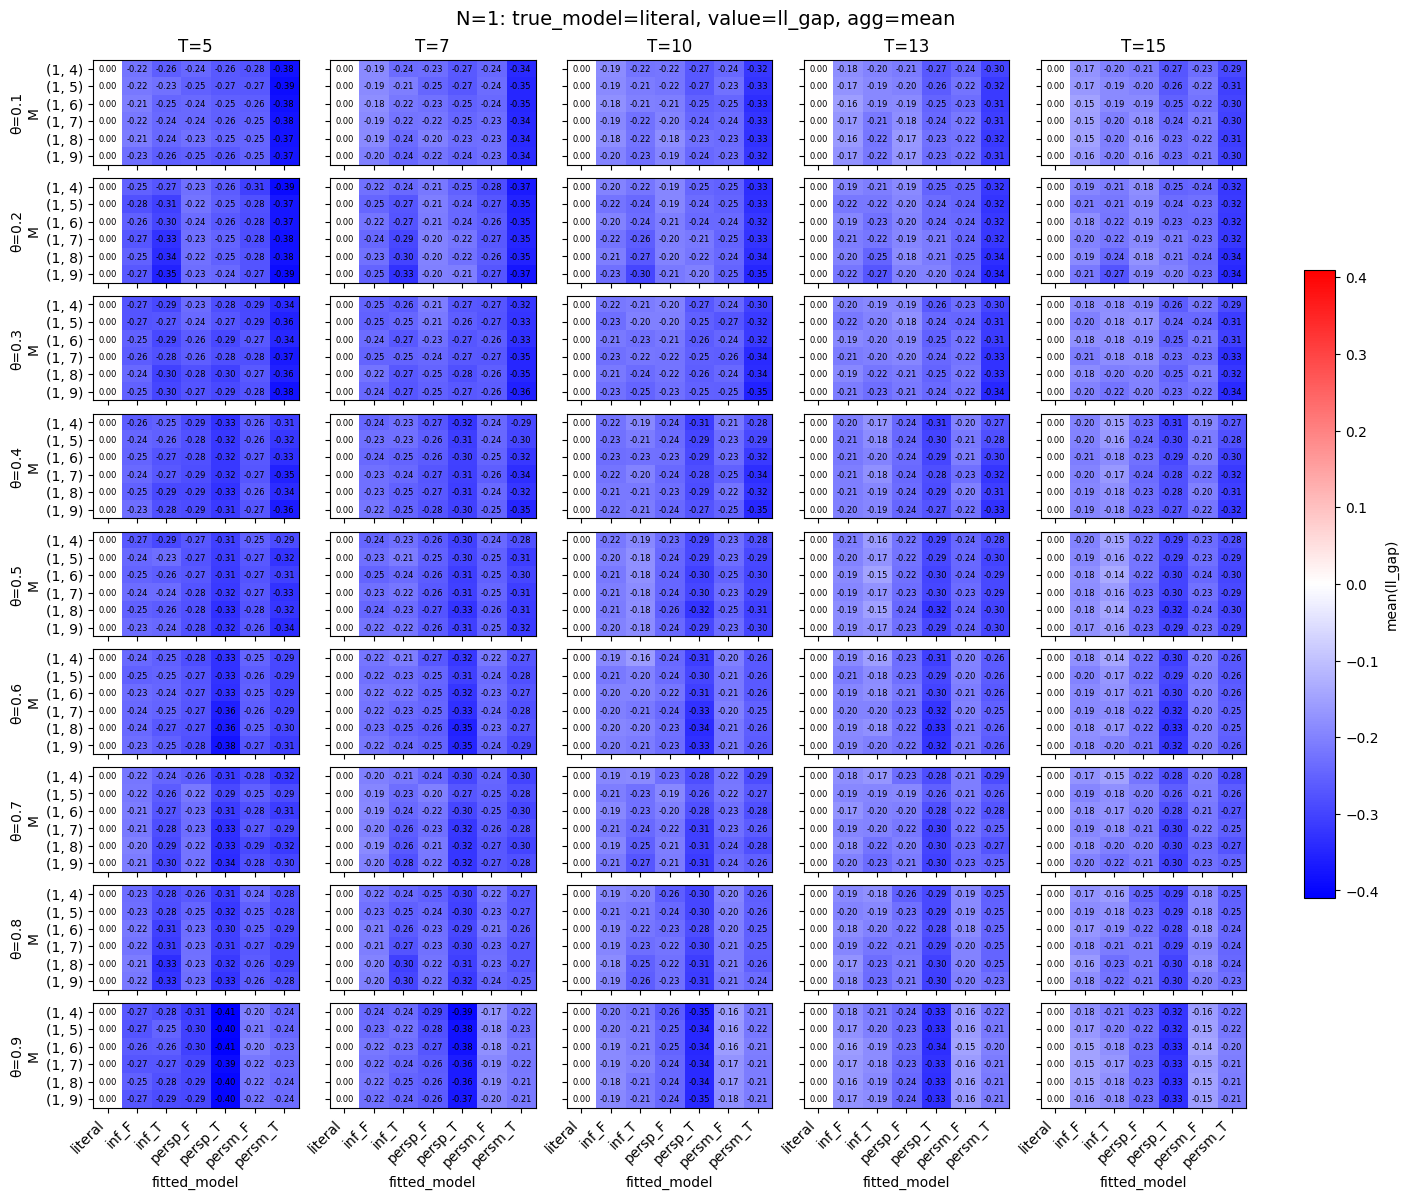

In [18]:
# Literal speaker: ll_gap
fig = plot_gap_grid_T_theta(df, true_model="literal", value_col="ll_gap", agg="mean")
plt.show()

## Informative speaker (static): ll_gap

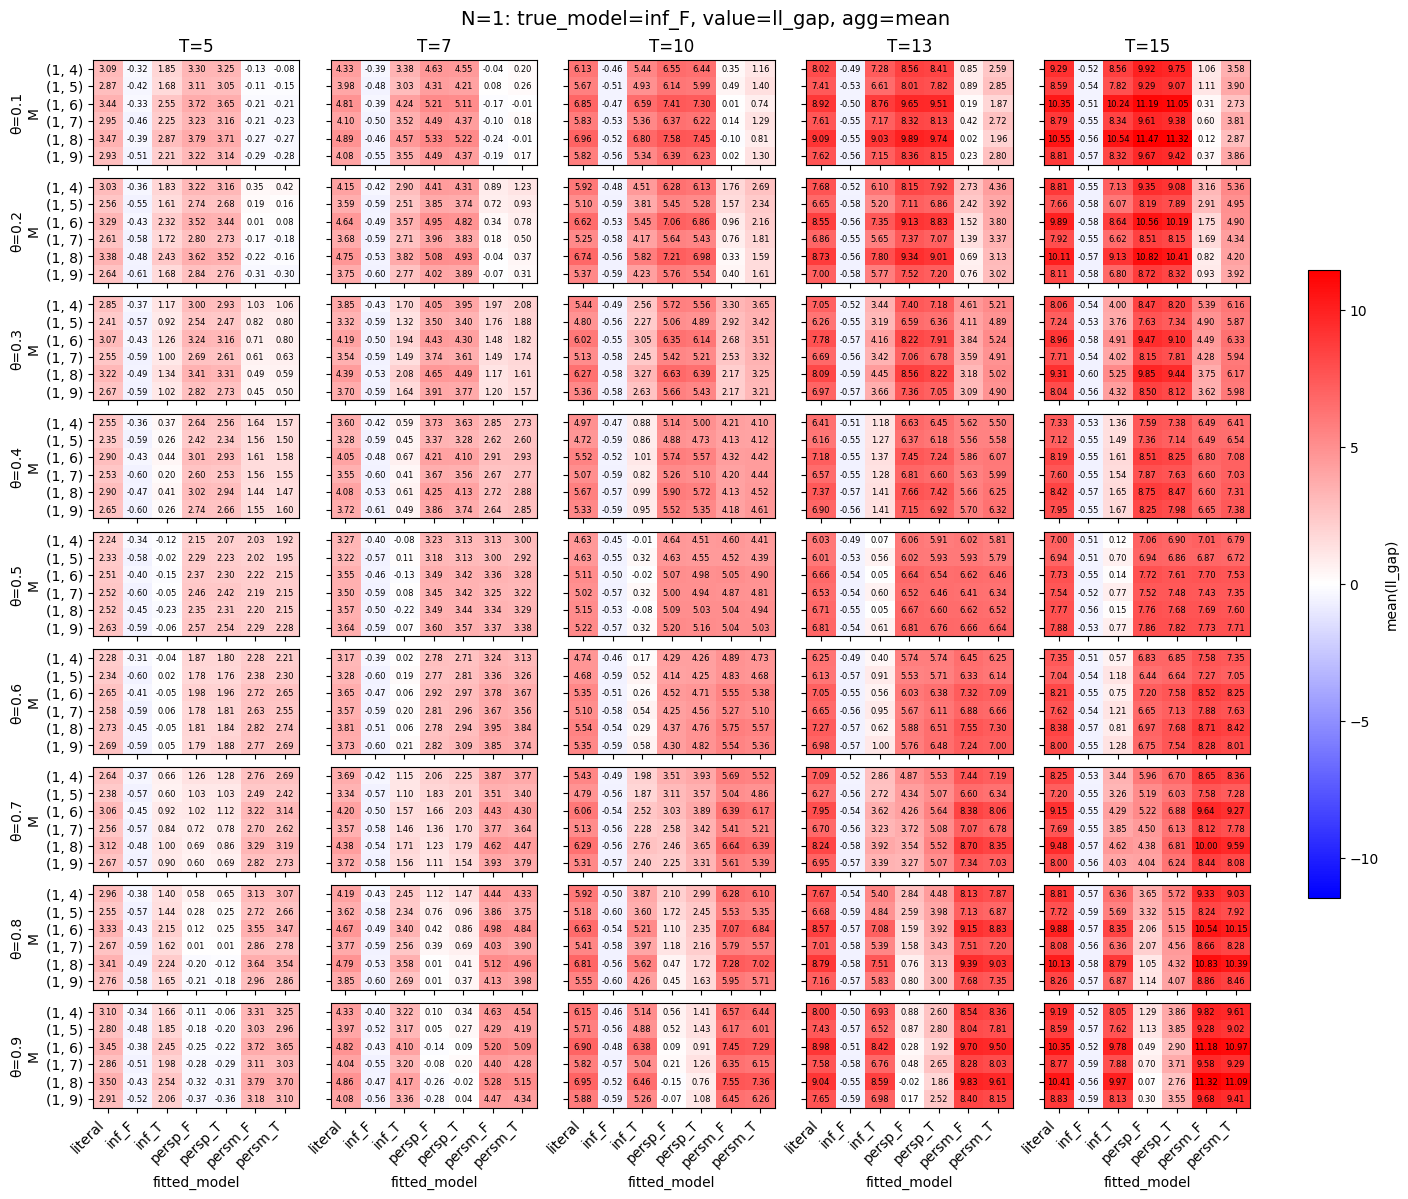

In [19]:
# Informative speaker (static): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="inf_F", value_col="ll_gap", agg="mean")
plt.show()

## Informative speaker (dynamic): ll_gap

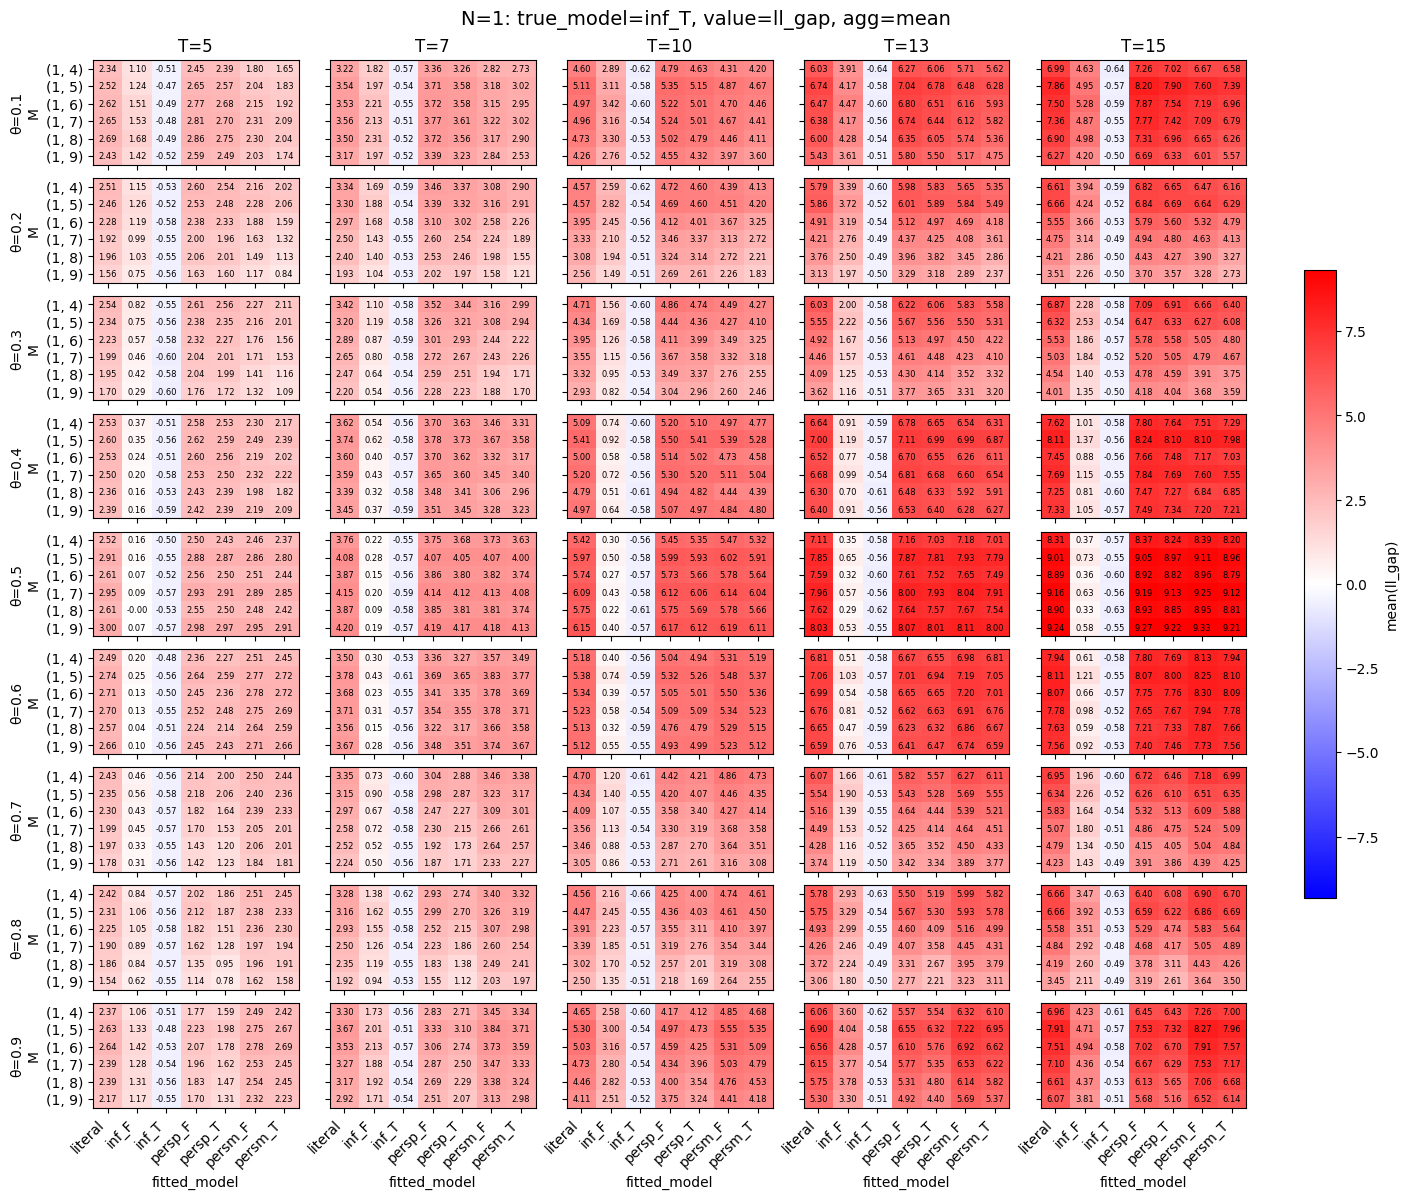

In [20]:
# Informative speaker (dynamic): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="inf_T", value_col="ll_gap", agg="mean")
plt.show()

## Persuade-up speaker (static): ll_gap

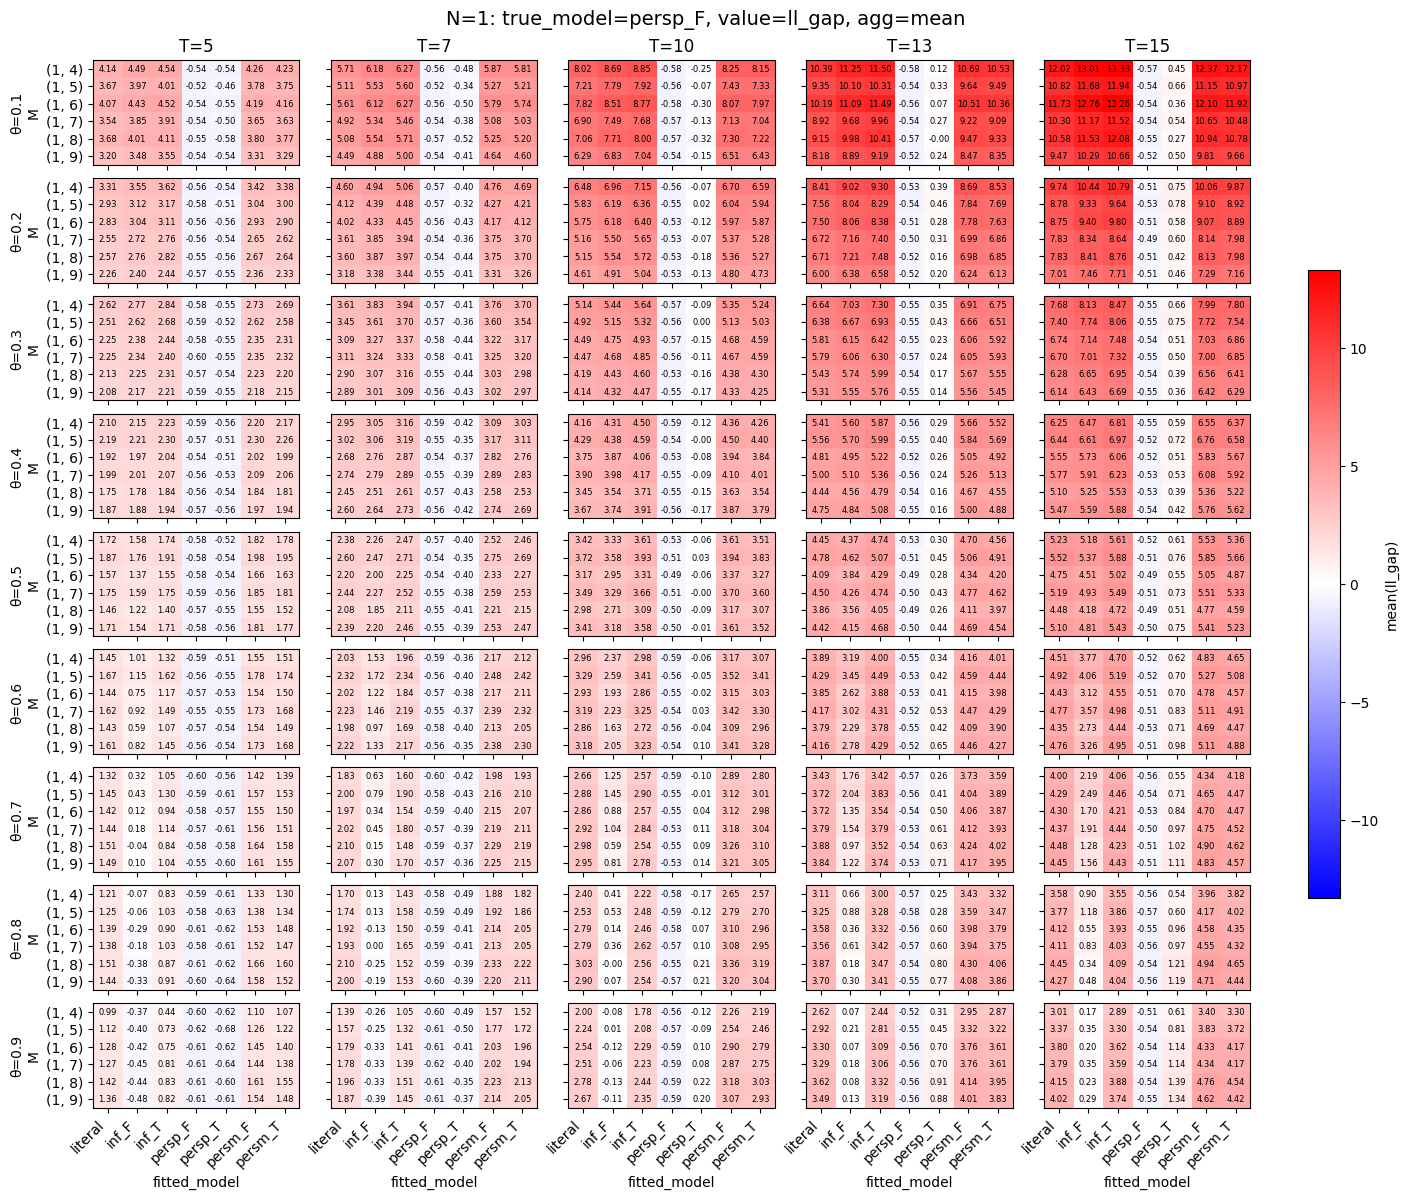

In [21]:
# Persuade-up speaker (static): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="persp_F", value_col="ll_gap", agg="mean")
plt.show()

## Persuade-up speaker (dynamic): ll_gap

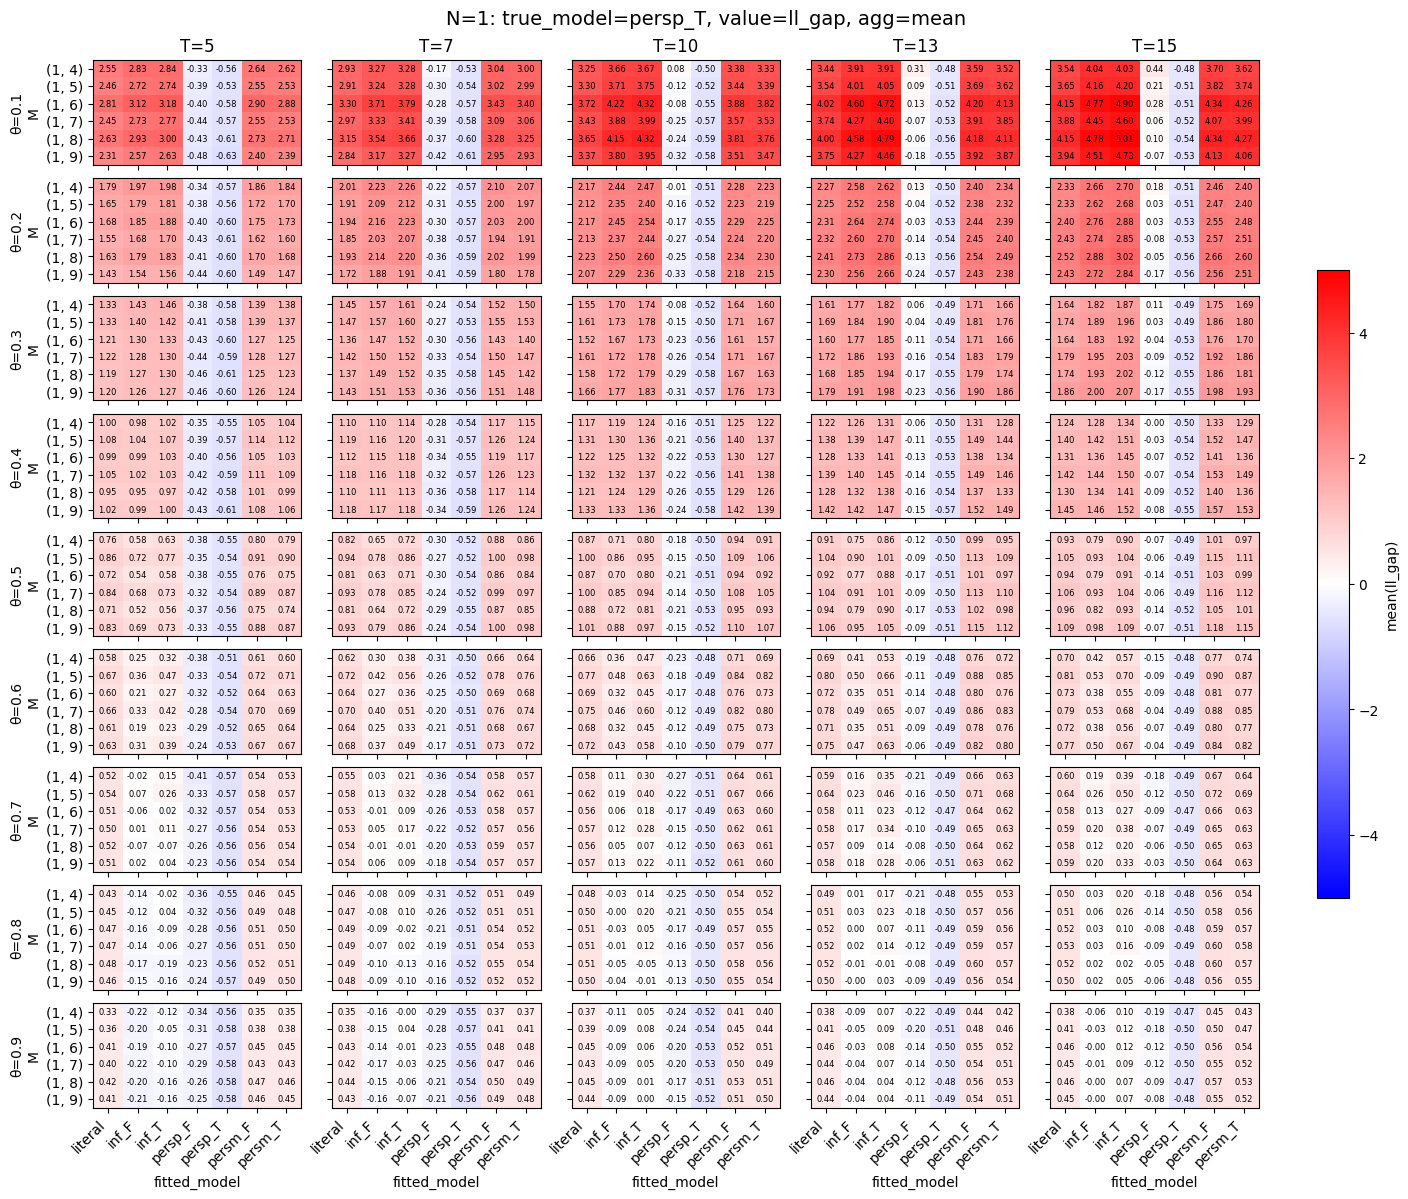

In [22]:
# Persuade-up speaker (dynamic): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="persp_T", value_col="ll_gap", agg="mean")
plt.show()

## Persuade-down speaker (static): ll_gap

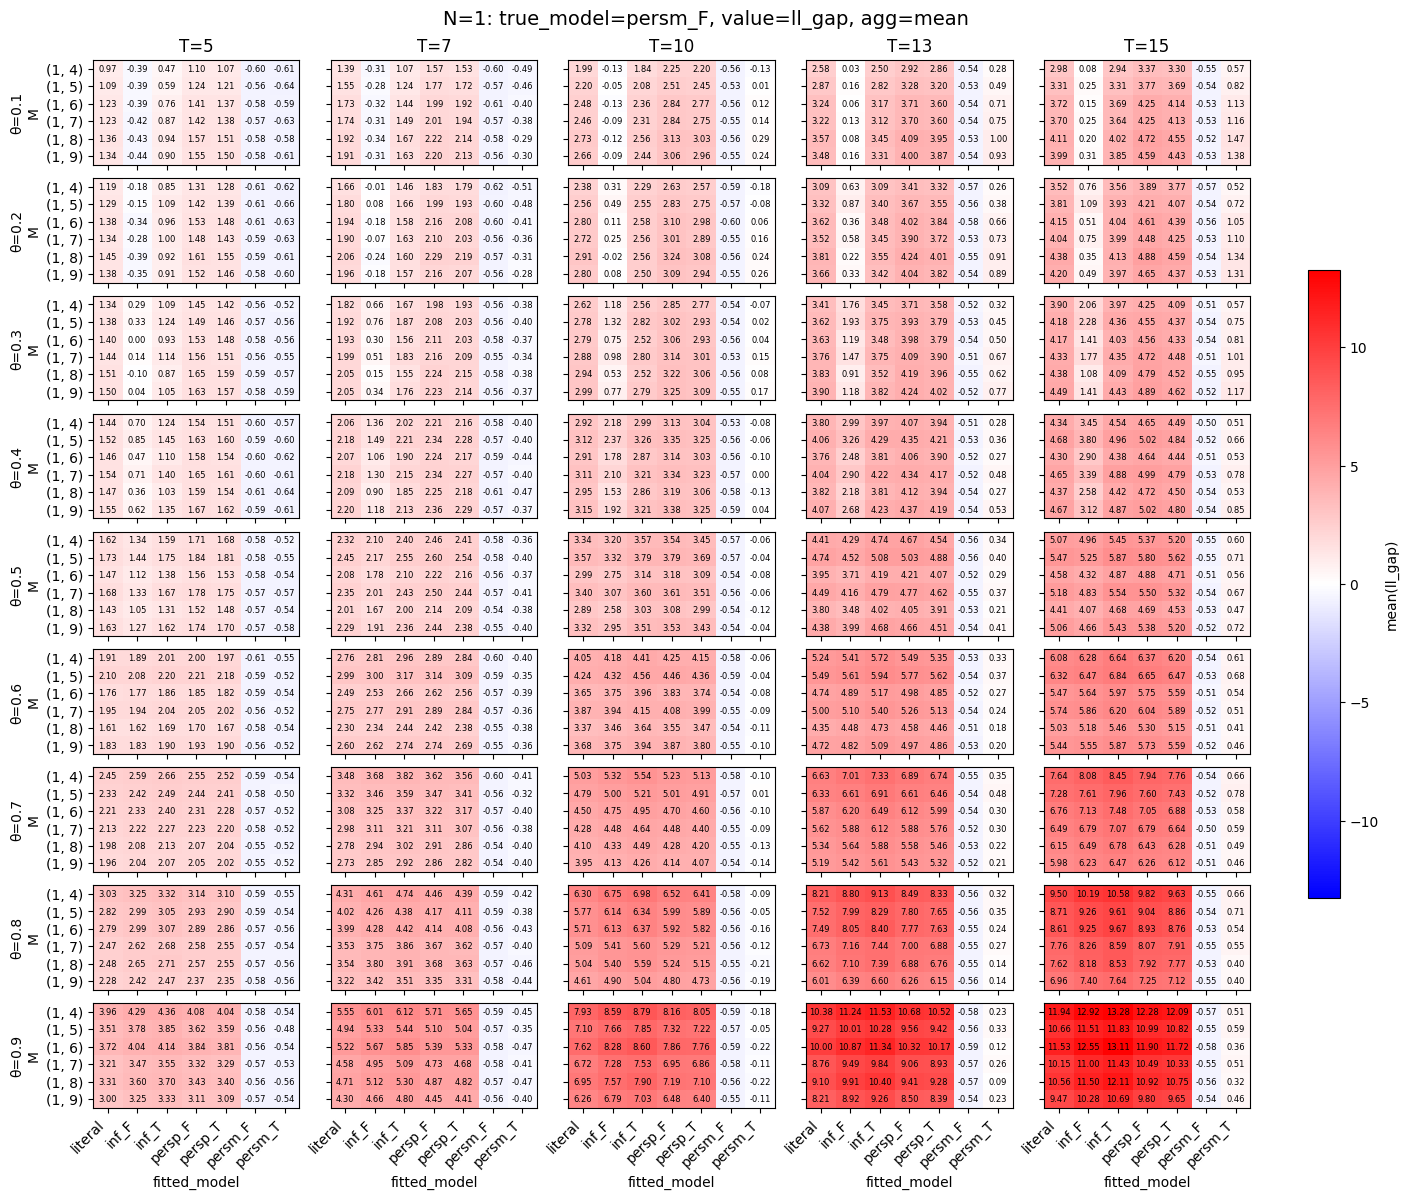

In [23]:
# Persuade-down speaker (static): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="persm_F", value_col="ll_gap", agg="mean")
plt.show()

## Persuade-down speaker (dynamic): ll_gap

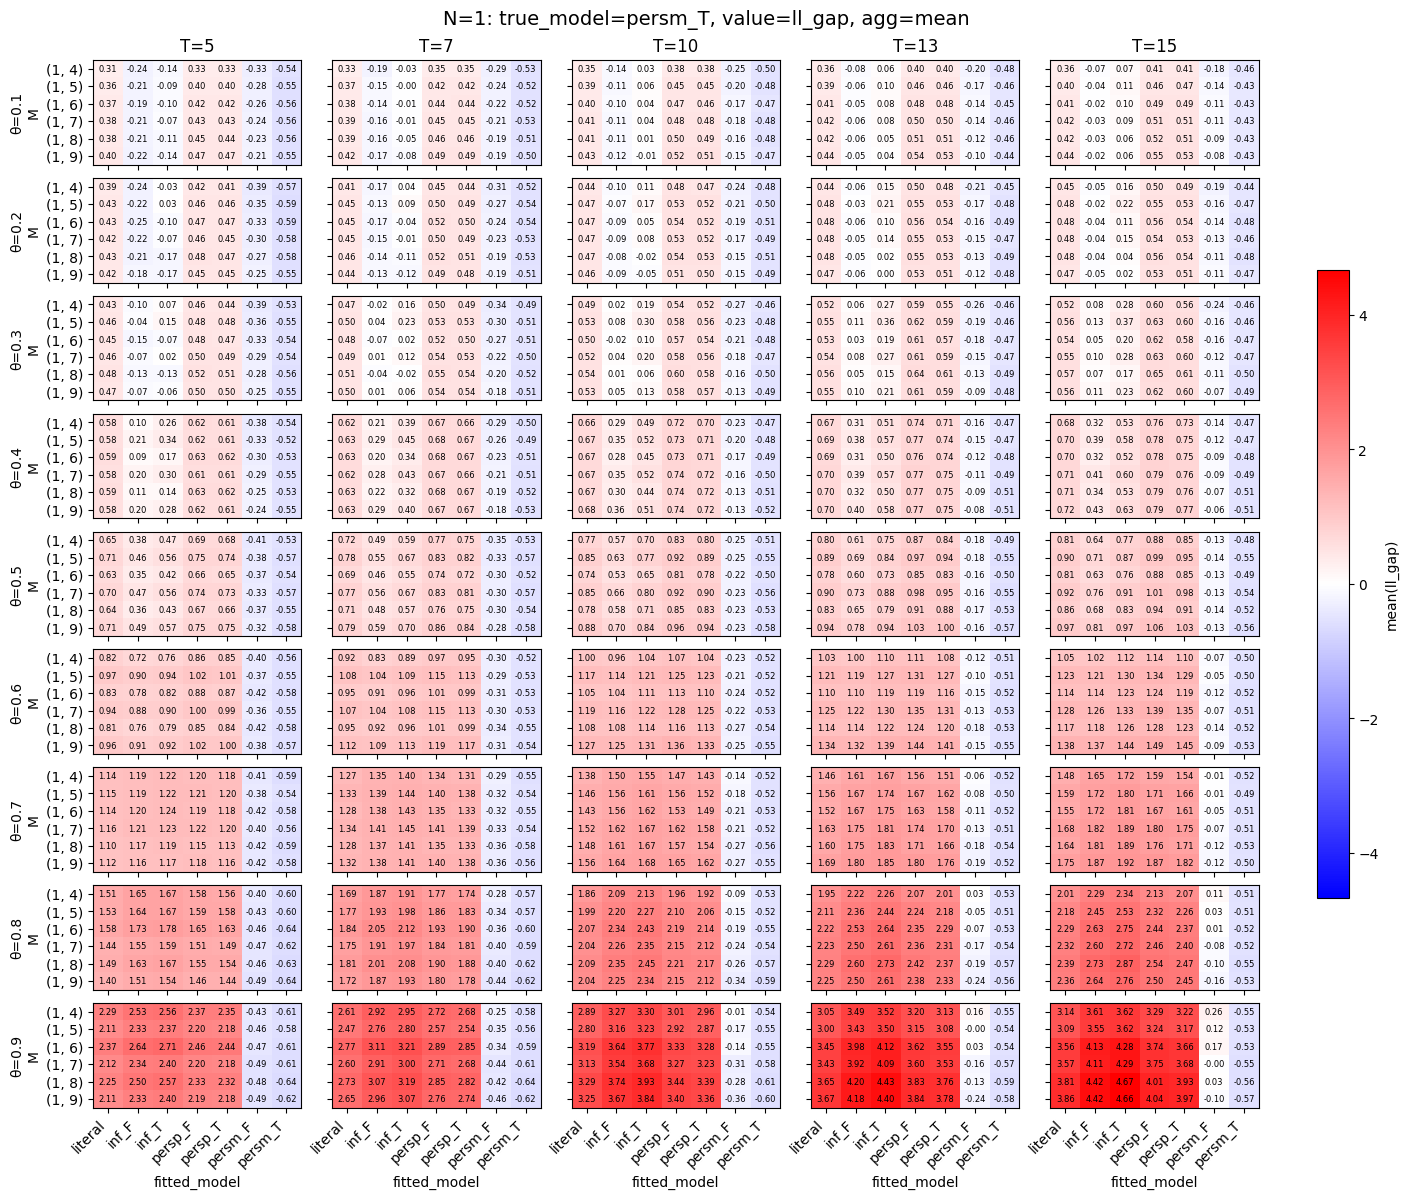

In [24]:
# Persuade-down speaker (dynamic): ll_gap
fig = plot_gap_grid_T_theta(df, true_model="persm_T", value_col="ll_gap", agg="mean")
plt.show()

# Analysis: Theta × Fitted Model Interactions

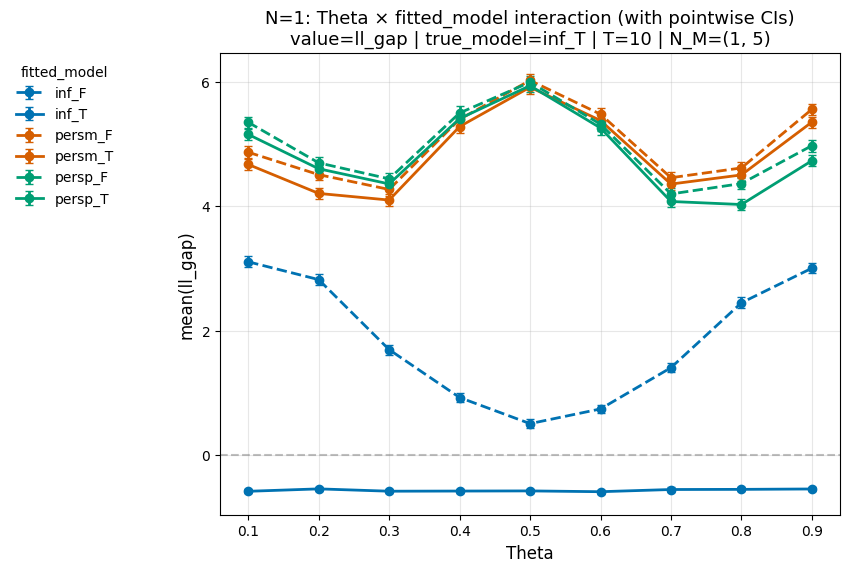

In [43]:
plot_theta_fitted_interaction_ci(df, true_model="inf_T", T=10, N_M="(1, 5)")
plt.show()

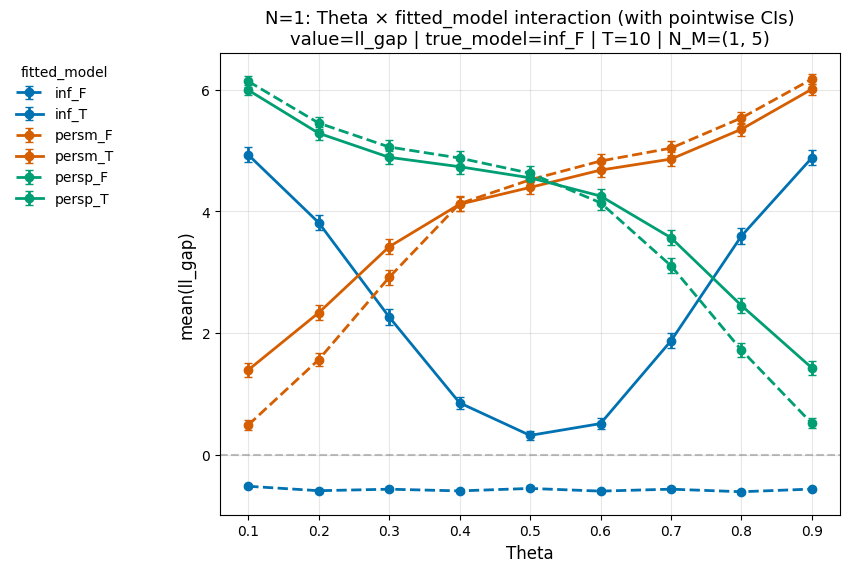

In [46]:
plot_theta_fitted_interaction_ci(df, true_model="inf_F", T=10, N_M="(1, 5)")
plt.show()

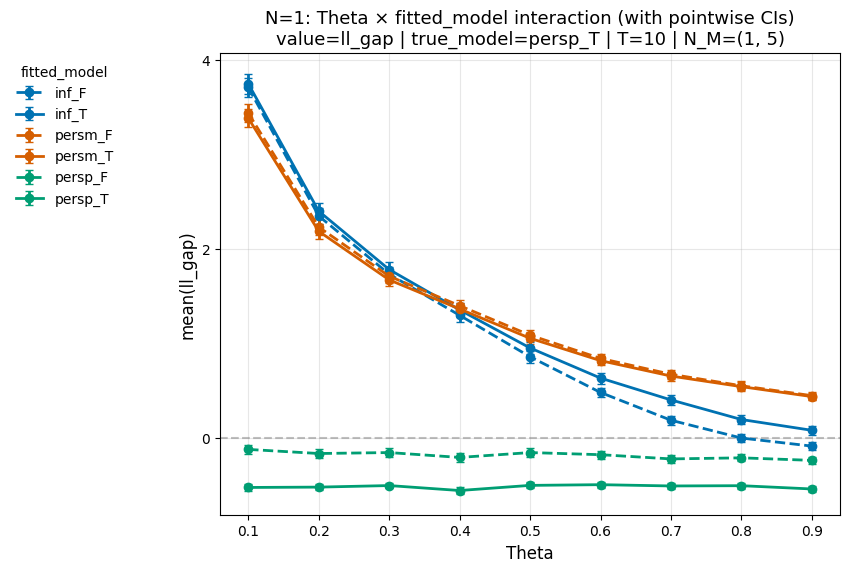

In [14]:
plot_theta_fitted_interaction_ci(df, true_model="persp_T", T=10, N_M="(1, 5)")
plt.show()

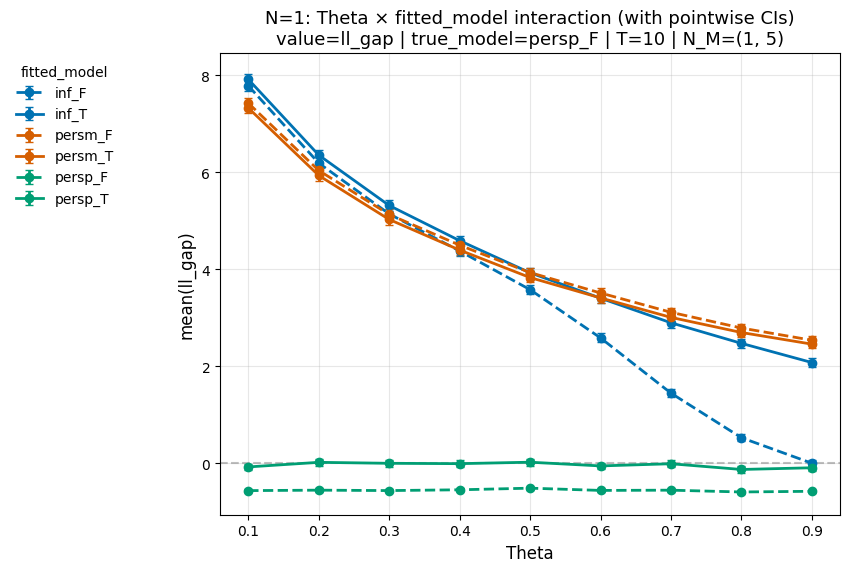

In [47]:
plot_theta_fitted_interaction_ci(df, true_model="persp_F", T=10, N_M="(1, 5)")
plt.show()

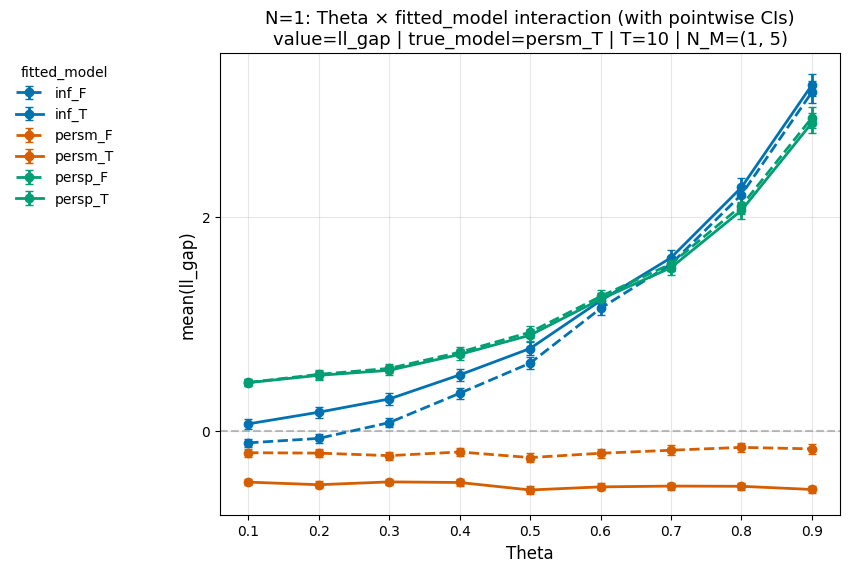

In [48]:
plot_theta_fitted_interaction_ci(df, true_model="persm_T", T=10, N_M="(1, 5)")
plt.show()

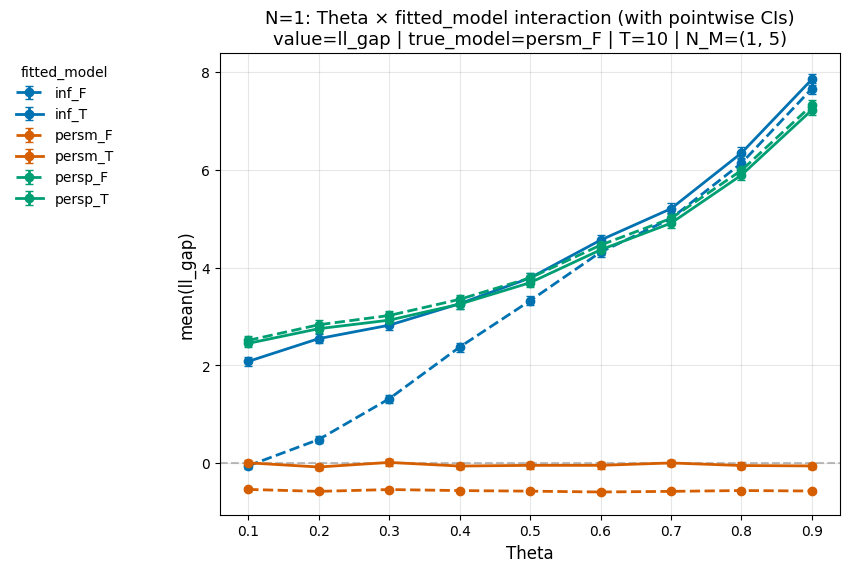

In [49]:
plot_theta_fitted_interaction_ci(df, true_model="persm_F", T=10, N_M="(1, 5)")
plt.show()

# Analysis: Compare M Values

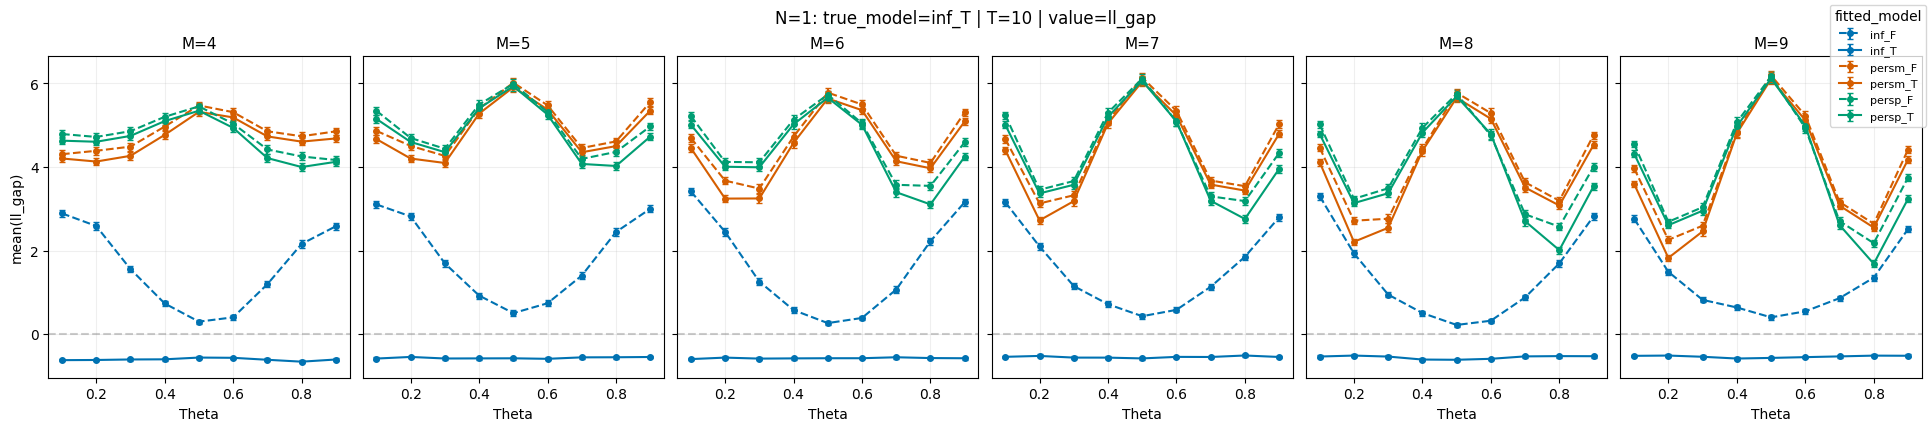

In [50]:
# Multi-panel: one per M value
fig = plot_theta_interaction_by_M_row(df, true_model="inf_T", T=10, value_col="ll_gap")
plt.show()

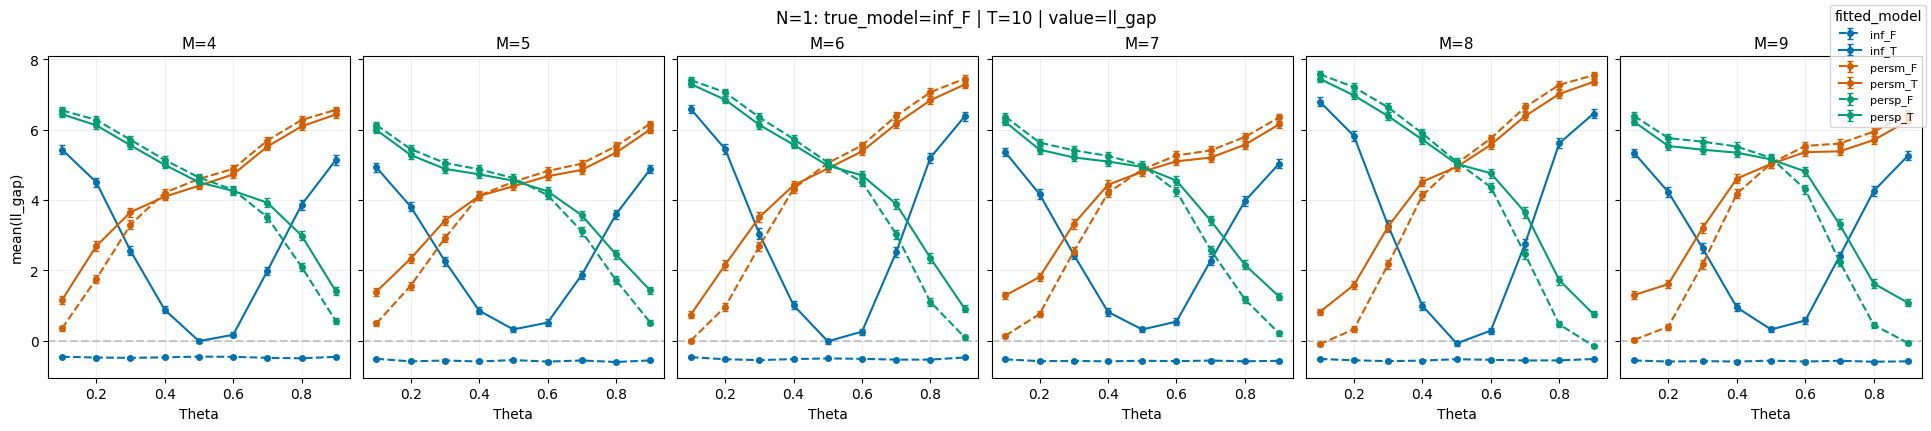

In [51]:
# Multi-panel: one per M value
fig = plot_theta_interaction_by_M_row(df, true_model="inf_F", T=10, value_col="ll_gap")
plt.show()

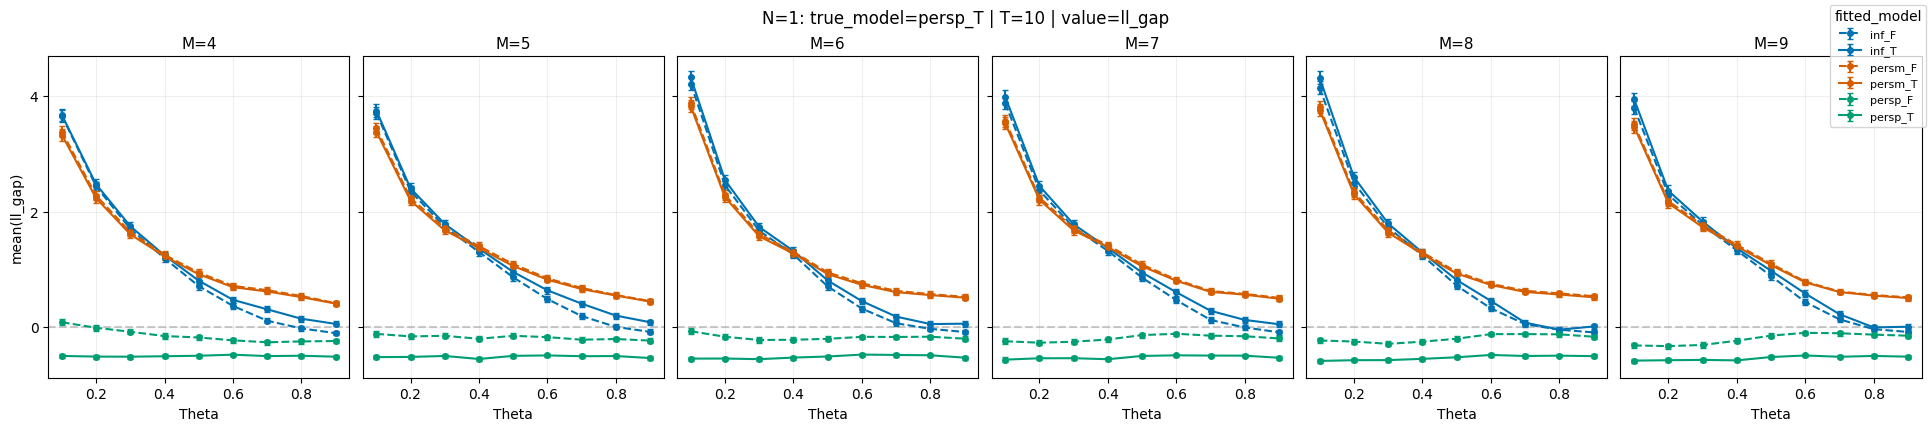

In [52]:
fig = plot_theta_interaction_by_M_row(df, true_model="persp_T", T=10, value_col="ll_gap")
plt.show()

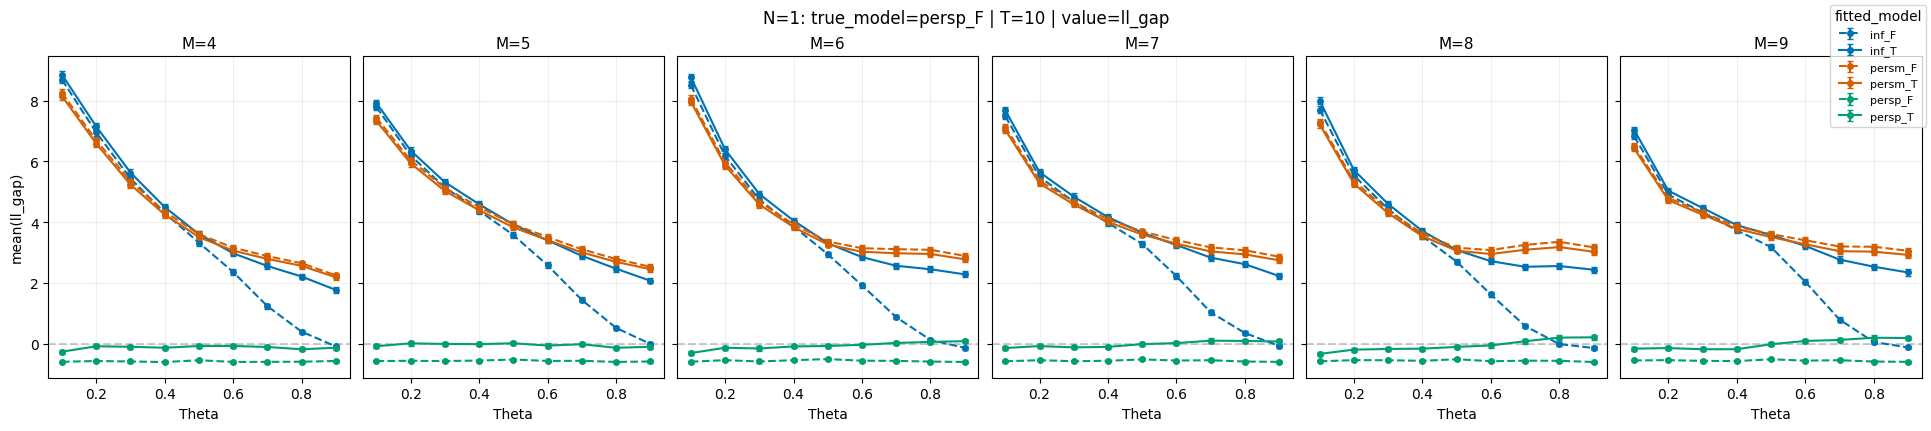

In [53]:
fig = plot_theta_interaction_by_M_row(df, true_model="persp_F", T=10, value_col="ll_gap")
plt.show()

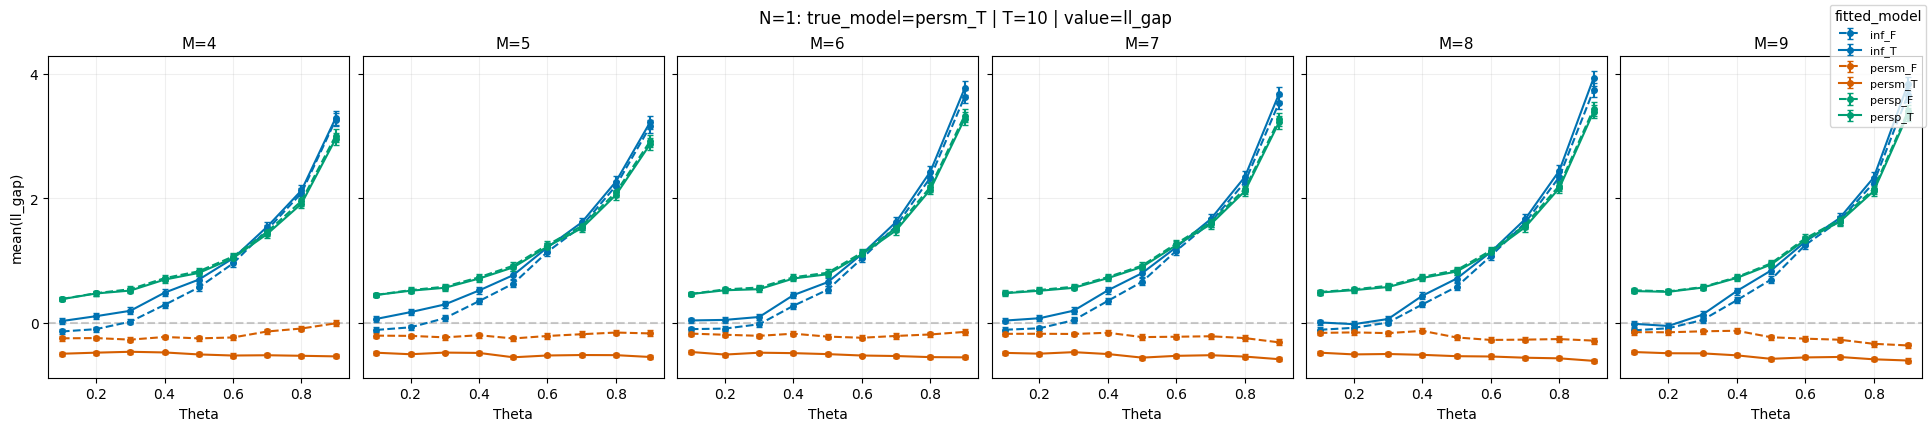

In [57]:
fig = plot_theta_interaction_by_M_row(df, true_model="persm_T", T=10, value_col="ll_gap")
plt.show()

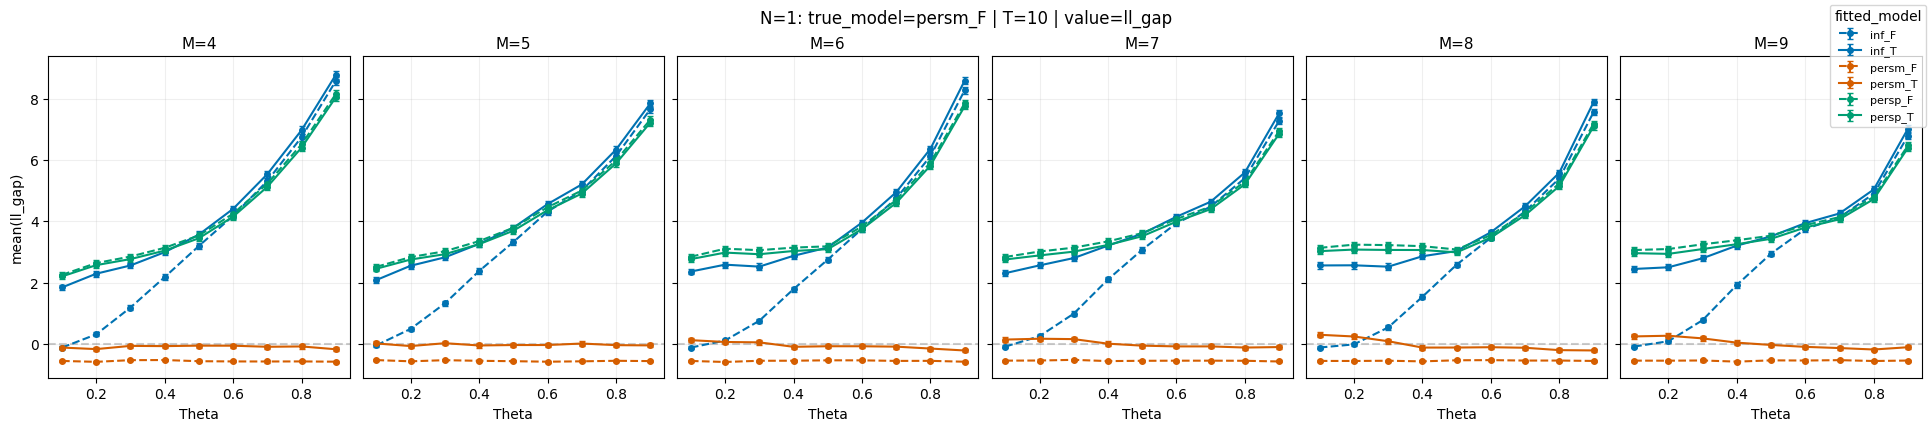

In [58]:
fig = plot_theta_interaction_by_M_row(df, true_model="persm_F", T=10, value_col="ll_gap")
plt.show()

# Analysis: M × Fitted Model Combined Plot

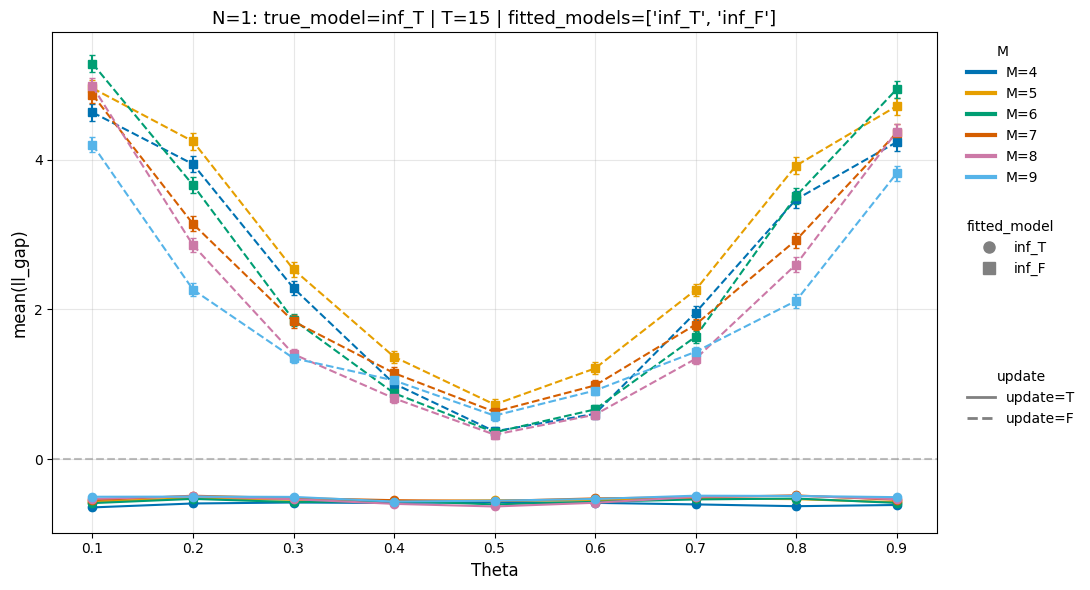

In [75]:
# Compare inf_T and inf_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="inf_T",
    T=15,
    fitted_models=["inf_T", "inf_F"],
    value_col="ll_gap",
)
plt.show()

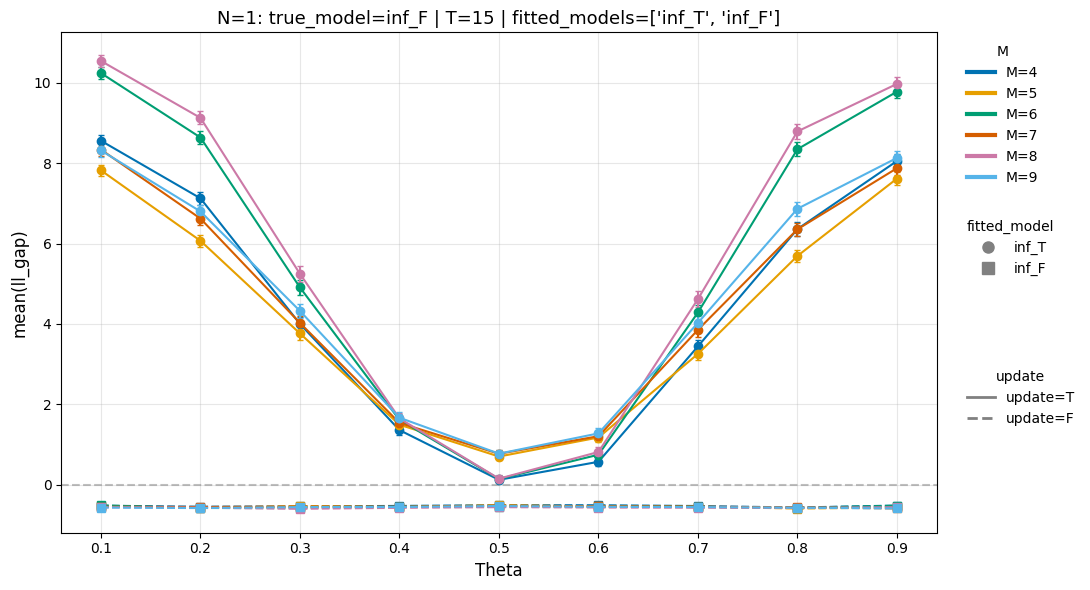

In [76]:
# Compare inf_T and inf_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="inf_F",
    T=15,
    fitted_models=["inf_T", "inf_F"],
    value_col="ll_gap",
)
plt.show()

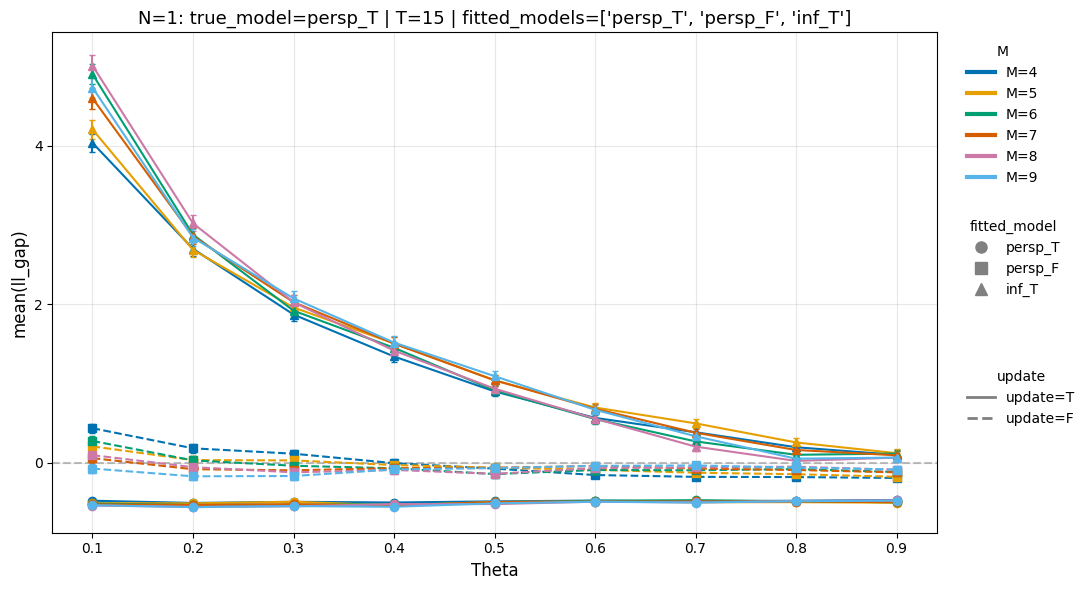

In [74]:
# Compare persp_T and persp_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="persp_T",
    T=15,
    fitted_models=["persp_T", "persp_F", "inf_T"],
    value_col="ll_gap",
)
plt.show()

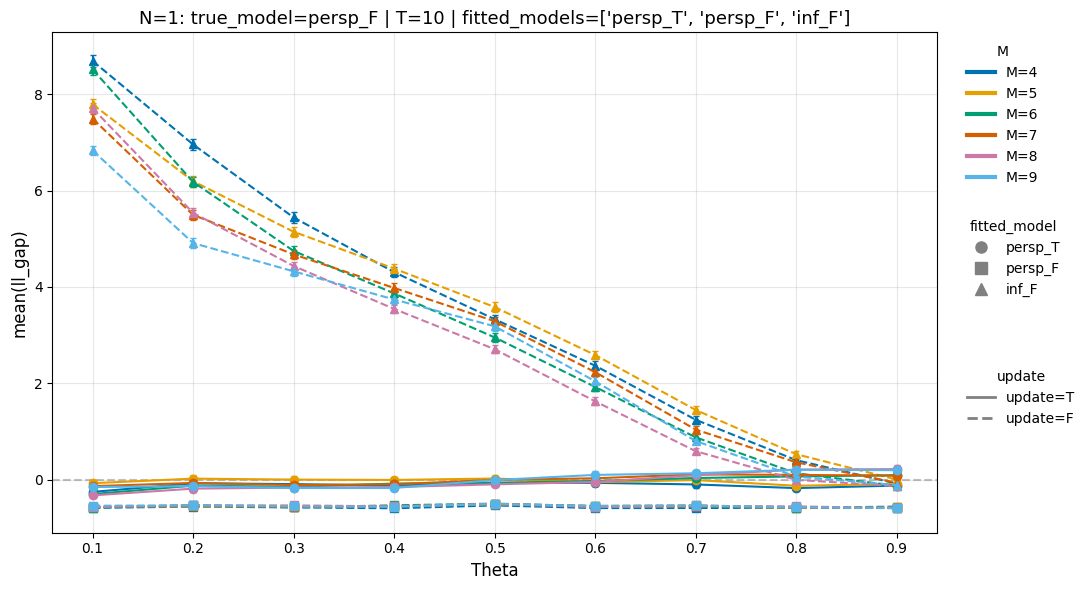

In [62]:
# Compare persp_T and persp_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="persp_F",
    T=10,
    fitted_models=["persp_T", "persp_F", "inf_F"],
    value_col="ll_gap",
)
plt.show()

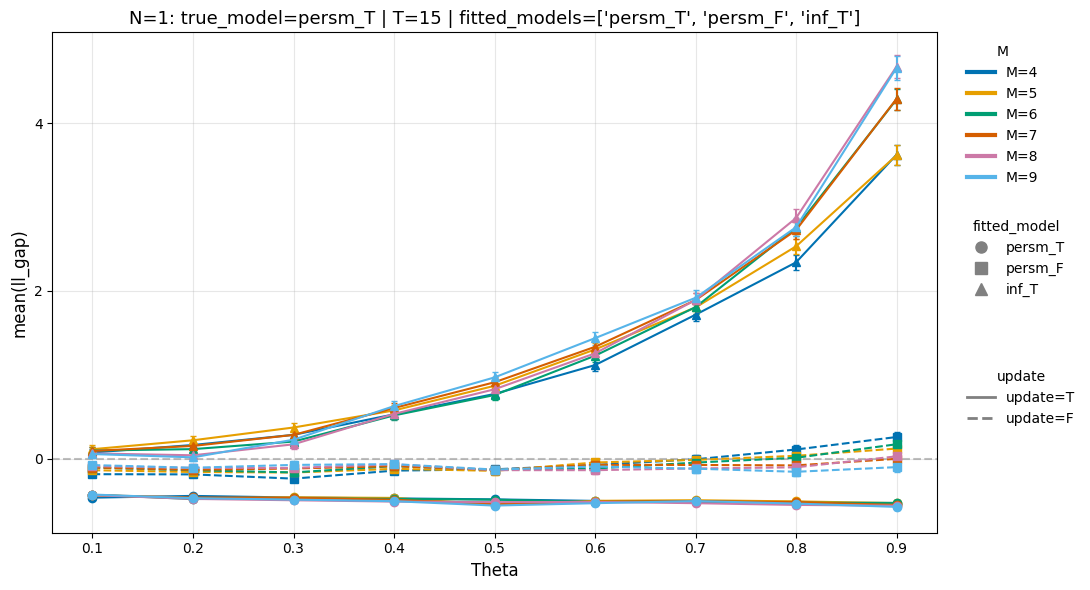

In [67]:
# Compare persm_T and persm_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="persm_T",
    T=15,
    fitted_models=["persm_T", "persm_F", "inf_T"],
    value_col="ll_gap",
)
plt.show()

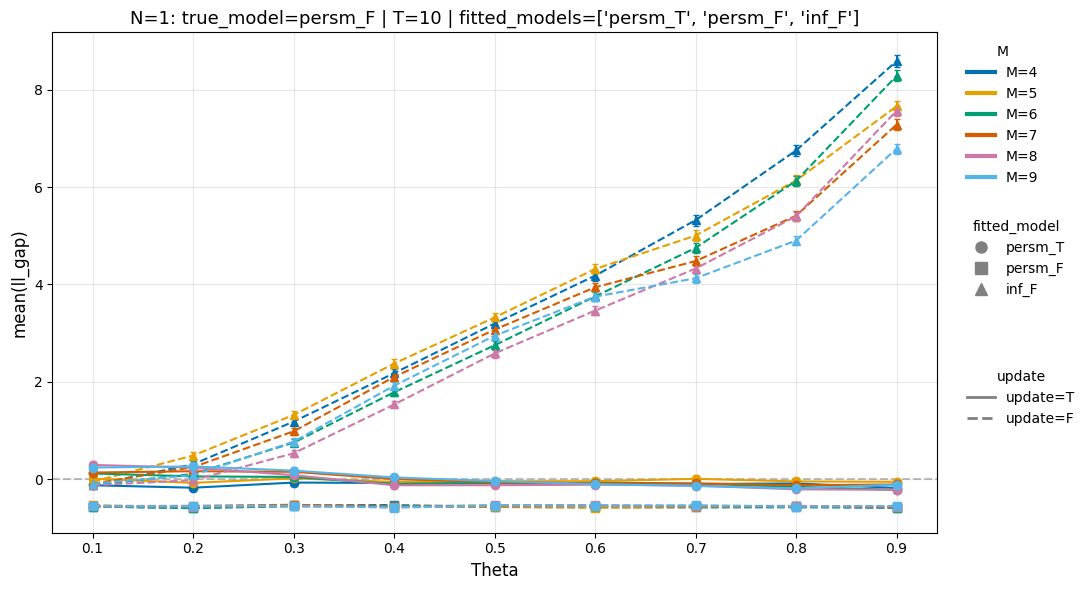

In [66]:
# Compare persm_T and persm_F across M values
fig = plot_M_colors_fm_markers(
    df,
    true_model="persm_F",
    T=10,
    fitted_models=["persm_T", "persm_F", "inf_F"],
    value_col="ll_gap",
)
plt.show()

# Summary Statistics

In [77]:
# Mean ll_gap by (true_model, fitted_model, M) at T=15
summary = (
    df[df["T"] == 15]
    .groupby(["true_model", "fitted_model", "M"])["ll_gap"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
summary["sem"] = summary["std"] / np.sqrt(summary["count"])

print("Mean ll_gap at T=15 (selected models):")
print(summary[summary["true_model"] == summary["fitted_model"]].to_string())

/tmp/ipykernel_11123/3792411491.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["true_model", "fitted_model", "M"])["ll_gap"]


Mean ll_gap at T=15 (selected models):
    true_model fitted_model  M      mean       std  count       sem
0        inf_F        inf_F  4 -0.529409  0.461871  18000  0.003443
1        inf_F        inf_F  5 -0.550208  0.752260  18000  0.005607
2        inf_F        inf_F  6 -0.552307  0.540945  18000  0.004032
3        inf_F        inf_F  7 -0.550774  0.743963  18000  0.005545
4        inf_F        inf_F  8 -0.570921  0.604085  18000  0.004503
5        inf_F        inf_F  9 -0.561797  0.762356  18000  0.005682
48       inf_T        inf_T  4 -0.599641  0.781254  18000  0.005823
49       inf_T        inf_T  5 -0.547314  0.752883  18000  0.005612
50       inf_T        inf_T  6 -0.562799  0.760268  18000  0.005667
51       inf_T        inf_T  7 -0.523900  0.734622  18000  0.005476
52       inf_T        inf_T  8 -0.543848  0.751702  18000  0.005603
53       inf_T        inf_T  9 -0.515544  0.735057  18000  0.005479
96     literal      literal  4  0.000000  0.000000  18000  0.000000
97     li

In [78]:
# Model recovery: When true_model=X, which fitted_model has highest likelihood?
def model_recovery_accuracy(df, T):
    """Compute how often the true model has the best fit."""
    sub = df[df["T"] == T].copy()
    
    # For each (true_model, M, theta, obs_id, utt_id), find the fitted_model with highest fitted_ll
    idx_best = sub.groupby(["true_model", "M", "theta", "obs_id", "utt_id"])["fitted_ll"].idxmax()
    best_fits = sub.loc[idx_best, ["true_model", "fitted_model", "M"]]
    
    # Check if true_model == fitted_model
    best_fits["correct"] = best_fits["true_model"] == best_fits["fitted_model"]
    
    accuracy = best_fits.groupby(["true_model", "M"])["correct"].mean().reset_index()
    accuracy.columns = ["true_model", "M", "accuracy"]
    
    return accuracy

accuracy_T15 = model_recovery_accuracy(df, T=15)
print("Model recovery accuracy at T=15:")
print(accuracy_T15.pivot(index="true_model", columns="M", values="accuracy").round(3).to_string())

/tmp/ipykernel_11123/119983253.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  idx_best = sub.groupby(["true_model", "M", "theta", "obs_id", "utt_id"])["fitted_ll"].idxmax()


Model recovery accuracy at T=15:
M               4      5      6      7      8      9
true_model                                          
inf_F       0.760  0.800  0.773  0.774  0.758  0.744
inf_T       0.889  0.926  0.901  0.915  0.892  0.900
literal     0.000  0.000  0.000  0.000  0.000  0.000
persm_F     0.674  0.702  0.669  0.689  0.667  0.683
persm_T     0.580  0.593  0.589  0.585  0.582  0.583
persp_F     0.672  0.699  0.673  0.685  0.664  0.677
persp_T     0.606  0.611  0.607  0.599  0.604  0.597


/tmp/ipykernel_11123/119983253.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accuracy = best_fits.groupby(["true_model", "M"])["correct"].mean().reset_index()


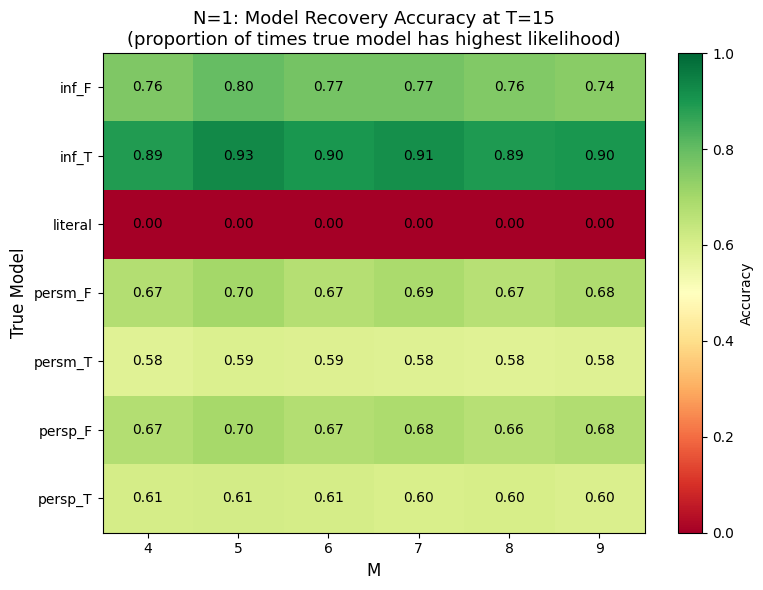

In [79]:
# Heatmap of recovery accuracy
accuracy_pivot = accuracy_T15.pivot(index="true_model", columns="M", values="accuracy")

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(accuracy_pivot.values, cmap="RdYlGn", vmin=0, vmax=1, aspect="auto")

ax.set_xticks(range(len(accuracy_pivot.columns)))
ax.set_xticklabels(accuracy_pivot.columns)
ax.set_yticks(range(len(accuracy_pivot.index)))
ax.set_yticklabels(accuracy_pivot.index)

ax.set_xlabel("M", fontsize=12)
ax.set_ylabel("True Model", fontsize=12)
ax.set_title("N=1: Model Recovery Accuracy at T=15\n(proportion of times true model has highest likelihood)", fontsize=13)

# Annotate
for i in range(len(accuracy_pivot.index)):
    for j in range(len(accuracy_pivot.columns)):
        val = accuracy_pivot.values[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=10)

plt.colorbar(im, ax=ax, label="Accuracy")
plt.tight_layout()
plt.show()

# Trace Back to Raw Data (Utility Function)

In [ ]:
import pickle
from pathlib import Path

def trace_back(row, results_dir: str) -> dict:
    """Given a DataFrame row, retrieve raw data from pickle."""
    N, M = int(row["N"]), int(row["M"])
    theta, obs_id, utt_id = float(row["theta"]), int(row["obs_id"]), int(row["utt_id"])
    true_model = str(row["true_model"])
    alpha_key = 0.0 if true_model == "literal" else 4.0
    
    with open(Path(results_dir) / f"screen_N{N}_M{M}_T15.pkl", "rb") as f:
        obs_data = pickle.load(f)
    
    obs_info = obs_data["observations"][theta][obs_id]
    utt_rec = obs_info["utterances"][true_model][alpha_key][utt_id]
    
    return {
        "obs_seq": obs_info["obs_seq"],
        "utt_seq": utt_rec["utt_seq"],
        "obs_info": obs_info,
        "utt_rec": utt_rec,
    }

# Example usage:
# raw = trace_back(df.iloc[0], RESULTS_DIR)
# print("Observation sequence:", raw["obs_seq"][:5])
# print("Utterance sequence:", raw["utt_seq"][:5])